### Название проекта
**Исследование объявлений о продаже квартир**

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. 

### Задача
установить параметры, которые позволят построить автоматизированную систему, отслеживающую аномалии и мошенническую деятельность

### Описание данных
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных (например, расстояние до центра, аэропорта, ближайшего парка и водоёма)


`airports_nearest` — расстояние до ближайшего аэропорта в метрах (м) \
`balcony` — число балконов \
`ceiling_height` — высота потолков (м) \
`cityCenters_nearest` — расстояние до центра города (м) \
`days_exposition` — сколько дней было размещено объявление (от публикации до снятия) \
`first_day_exposition` — дата публикации \
`floor` — этаж \
`floors_total` — всего этажей в доме \
`is_apartment` — апартаменты (булев тип) \
`kitchen_area` — площадь кухни в квадратных метрах (м²) \
`last_price` — цена на момент снятия с публикации \
`living_area` — жилая площадь в квадратных метрах (м²) \
`locality_name` — название населённого пункта \
`open_plan` — свободная планировка (булев тип) \
`parks_around3000` — число парков в радиусе 3 км \
`parks_nearest` — расстояние до ближайшего парка (м) \
`ponds_around3000` — число водоёмов в радиусе 3 км \
`ponds_nearest` — расстояние до ближайшего водоёма (м) \
`rooms` — число комнат \
`studio` — квартира-студия (булев тип) \
`total_area` — общая площадь квартиры в квадратных метрах (м²) \
`total_images` — число фотографий квартиры в объявлении

### План исследования:

- **Открытие файла с данными и изучение общей информации**
- **Предобработка данных:**
            Изучение и заполнение пропусков
            Изучение типов данных
            Изучение и обработка аномалий
            Изучение и обработка дубликатов
            Добавление в таблицу доп. столбцов для исследовательского анализа
- **Исследовательский анализ данных:**
            Связь числа предложений и различных параметров квартиры
            Связь стоимости/цены 1 кв.м и различных параметров квартиры
            Топ-10 населённых пунктов датафрейма по объёмам продаж
            Связь цены 1 кв.м. и удалённости квартиры от центра Санкт-Петербурга
- **Общий вывод**

## Открытие файла с данными

In [1]:
#  импортируем основные библиотеки
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#  читаем файл с локальной машины или с удалённого сервера (метод try - except)
try:
    data = pd.read_csv("/real_estate_data.csv", sep='\t')
except:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/real_estate_data.csv", sep='\t')

In [3]:
# устанавливаем отображение полного содержимого ячеек
pd.set_option('display.max_rows', 25)

### Изучение общей информации

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


In [6]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [7]:
data.tail(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23689,13,3550000.0,35.30,2018-02-28T00:00:00,1,2.86,15.0,16.3,4,NaN,...,9.10,2.0,Санкт-Петербург,17284.0,16081.0,1.0,353.0,2.0,652.0,29.0
23690,3,5500000.0,52.00,2018-07-19T00:00:00,2,NaN,5.0,31.0,2,NaN,...,6.00,NaN,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0
23691,11,9470000.0,72.90,2016-10-13T00:00:00,2,2.75,25.0,40.3,7,NaN,...,10.60,1.0,Санкт-Петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,519.0
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.5,4,NaN,...,6.00,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23693,9,4600000.0,62.40,2016-08-05T00:00:00,3,2.60,9.0,40.0,8,NaN,...,8.00,0.0,Петергоф,45602.0,34104.0,1.0,352.0,1.0,675.0,239.0
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.30,2017-07-21T00:00:00,1,2.50,5.0,12.3,1,NaN,...,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*Дополнительно изучим гистограммы по числовым данным*

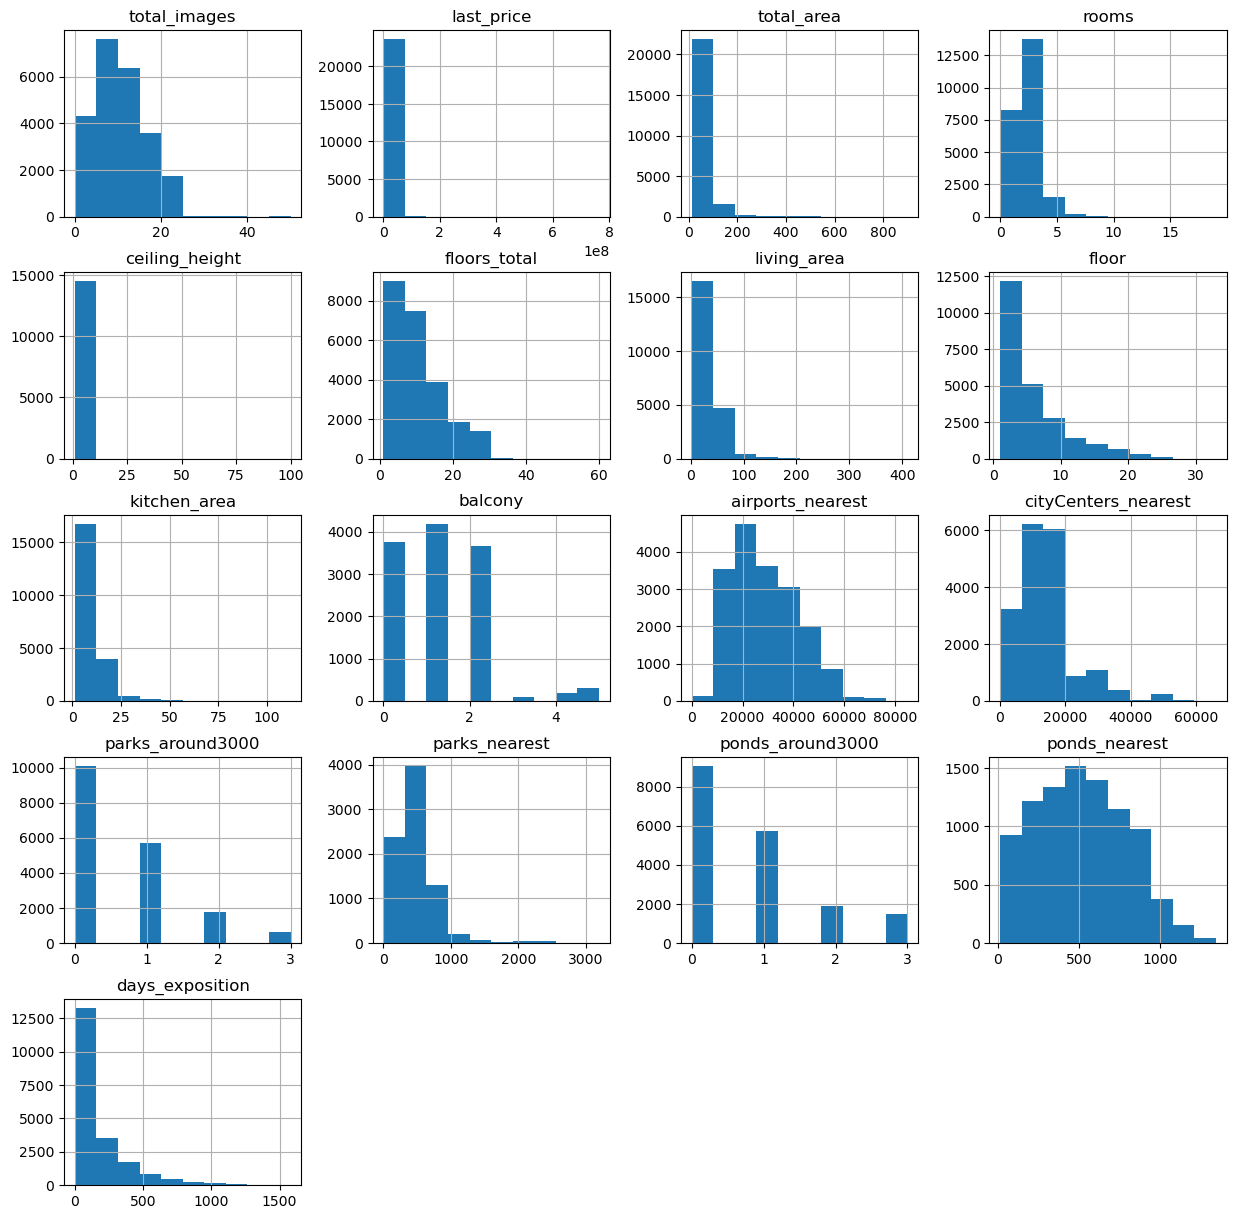

In [8]:
data.hist(figsize=(15, 15));

**Выводы:**

- полученный массив содержит данные различных типов, числовые и категориальные
- набор данных отличается неполнотой, в нём имеются явные аномалии в значениях, несоответствие типов данных и т.п.
- прежде, чем мы сможем проанализировать данные и сделать выводы о параметрах, необходимо произвести преобработку

## Предобработка данных

### Изучение и заполнение пропусков в данных

In [9]:
#изучим число пропусков в каждом из столбцов датафрейма
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Выводы**
- налицо большое (от 20 до 50%) число пропусков во всех картографических данных, а также ряд пропусков в заполненных пользователем данных: `ceiling_height`, `living_area`, `is_apartment`, `kitchen_area`, etc...

Пропуски в картографических данных возможны по следующим причинам:
- слияние данных из разных датафреймов, для одного (или нескольких) из которых измерения расстояний и расчёт числа объектов не осуществлялись и как результат - их нет в итоговом датафрейме, который мы рассматриваем
- сбой при объединении (например, из-за различия в указанных единицах измерения)

Пропуски в "пользовательских" данных возможны по следующим причинам:
- заполнение анкет без документов о собственности на руках, в результате чего ряд "незапоминающихся" параметров (высота потолков, жилая площадь и площадь кухни) не были указаны
- реализация выбора ("апартаменты"/"не апартаменты") через чекбоксы, заполнение которых не обязательно для подачи анкеты, как результат - только 10% пользователей указали этот параметр
- "по умолчанию" число балконов не объявлялось, как результат - владельцы квартир без балконов не заполнили этот пункт
- отсутствие данных в пункте о полном числе этажей и наименовании населённого пункта может быть вызвано техническими сбоями при переносе (и/или объединении) данных

**Предполагаемые способы коррекции недостающих сведений в датафрейме:**

- `locality_name` - можно заполнить по моде столбца (но это может повлечь за сообой ошибки), корректнее заполнить однородными значениями (напр. Unknown) /или удалить строки/
- `balcony` - предположительно, пропуски в данных указывают на отсутствие балконов в квартире, заполним пропуски 0
- `is_apartment` - важный критерий при выборе квартиры, но в дальнейшем анализе данных не задействован, можем как удалить столбец, так и заполнить пропуски преобладающим значением (предположительно `False`)
- `days_exposition` - пропуски в этом столбце могут быть вызваны тем, что на момент выгрузки данных жилой объект ещё не был снят с продажи/продан, изучим характер и распределение пропусков, после чего решим, каким образом их заполнять
- `floors_total` - учитывая незначительное (~0,3% от общего набора данных) число пропусков (и как результат - незначительное влияние на итоговый анализ) удалим строки с пропущенными в этом столбце значениями
- `ceiling_height` - так как параметр стандартизуется (и, исходя из общих соображений, находится в диапазоне 2,4-4 м), - заполним пропуски значением медианы, как наиболее устойчивой к выбросам и отклонениям величиной
- `living_area`, `kitchen_area` - нестандартизуемые параметры, попробуем поискать закономерности в соотношении площадей в квартирах различной total_area, если получится, то заполним пропущенные значения на этом основании(или оставим пропуски в данных)
`airports_nearest` - возможно заполнение пропусков по медиане для каждого конкретного населённого пункта (кроме уникальных значений*)
`cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` - картографические данные, нет возможности самостоятельно произвести необходимые измерения, вероятно, придётся оставить пропуски в этих данных незаполненными

При заполнении пропусков, будем выводить на экран сведения о числе пропусков в столбце до и после заполнения

    *В случае уникальных значений (т.е. когда объект с незаполненными данными - единственный в своём населённом пункте), при их сравнительно малом количестве оставим такие ячейки без заполнения

*Заполним отсутствующие в `locality_name` значения на "Unknown"*

In [10]:
print('Пропуски до внесения изменений:', data['locality_name'].isna().sum())
data['locality_name'].fillna('Unknown', inplace=True)
print('Пропуски после внесения изменений:', data['locality_name'].isna().sum())

Пропуски до внесения изменений: 49
Пропуски после внесения изменений: 0


*Заполним нулями отсутствующие значения в `balcony`*

In [11]:
print('Пропуски до внесения изменений:', data['balcony'].isna().sum())

data['balcony'].fillna(0, inplace=True)

print('Пропуски после внесения изменений:', data['balcony'].isna().sum())

Пропуски до внесения изменений: 11519
Пропуски после внесения изменений: 0


*Определим моду (среди заполненных значений) в столбце `is_apartment`*

In [12]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

*Заполним модой пропущенные значения для этого столбца*

In [13]:
print('Пропуски до внесения изменений:', data['is_apartment'].isna().sum())

data['is_apartment'].fillna(False, inplace=True)

print('Пропуски после внесения изменений:', data['is_apartment'].isna().sum())

Пропуски до внесения изменений: 20924
Пропуски после внесения изменений: 0


In [14]:
print('Пропуски до внесения изменений:', data['floors_total'].isna().sum())

Пропуски до внесения изменений: 86


In [15]:
data.dropna(subset=['floors_total'],inplace=True)

In [16]:
print('Пропуски после внесения изменений:', data['floors_total'].isna().sum())

Пропуски после внесения изменений: 0


*После удаления строк переустановим индекс в датафрейме*

In [17]:
data.reset_index(drop=True, inplace= True)

*Изучим столбец `days_exposition`:*

базовая гипотеза - пропущенные значения в нём соответствуют сравнительно недавнему размещению объявления и жилой объект на момент выгрузки данных ещё не был продан (или объявление с ним не было удалено из базы)*

*Сперва преобразуем значения в столбце `first_day_exposition` в формат DateTime для удобства работы с данными*

In [18]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format="%Y-%m-%dT%H:%M:%S")

*Построим гистаграмму зависимости числа NaN значений в столбце `days_exposition` от значений в столбце `first_day_exposition`*

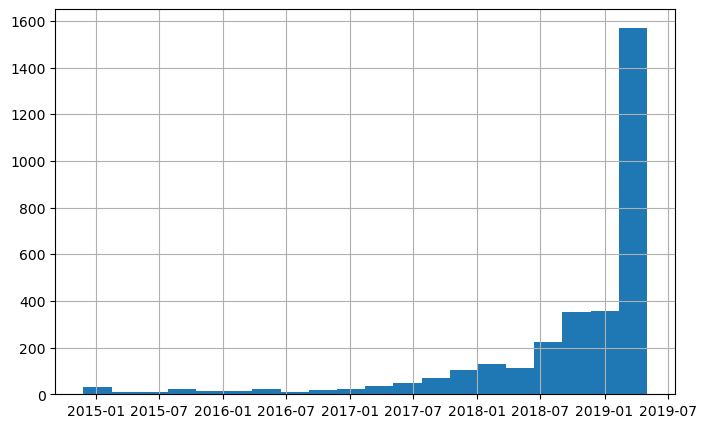

In [19]:
data.query('days_exposition.isna()')['first_day_exposition'].hist(bins=20, figsize=(8,5));

Гипотеза подтверждается: основная масса объявлений, по которым отсутствует срок нахождения в базе, размещены сравнительно недавно, менее года (на момент последнего объявления/выгрузки данных). Чтобы искусственно не изменять число проданных/снятых с размещения квартир, оставим пропуски в этом столбце незаполненными, оставив при этом сведения о квартирах в датафрейме*

*Заполняем пропуски в столбцах `airports_nearest`, `cityCenters_nearest`, `ceiling_height` медианными значениями (используя методы `groupby` и `transform`):*

In [20]:
print('Пропуски до внесения изменений:', data['airports_nearest'].isna().sum())

Пропуски до внесения изменений: 5532


In [21]:
data['airports_nearest'] = data['airports_nearest'].fillna(data.groupby('locality_name')['airports_nearest'].transform('median'))

In [22]:
print('Пропуски после внесения изменений:', data['airports_nearest'].isna().sum())

Пропуски после внесения изменений: 5432


**Вывод:**
Заполнение пропусков расстояния до аэропорта (по медиане для каждого населённого пункта) не позволило существенно сократить число NaN ячеек, вероятно, из-за большого количества населённых пунктов, для которых расчёт такого расстояния не был произведён вовсе. При дальнейшем анализе учтём это.

In [23]:
print('Пропуски до внесения изменений:', data['cityCenters_nearest'].isna().sum())

Пропуски до внесения изменений: 5509


In [24]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data.groupby('locality_name')['cityCenters_nearest'].transform('median'))

In [25]:
print('Пропуски после внесения изменений:', data['cityCenters_nearest'].isna().sum())

Пропуски после внесения изменений: 5432


**Вывод:**
Заполнение пропусков расстояния до центра города (по медиане для каждого населённого пункта) не позволило существенно сократить число NaN ячеек, вероятно, из-за большого количества населённых пунктов, для которых расчёт такого расстояния не был произведён вовсе. При дальнейшем анализе учтём это.

In [26]:
print('Пропуски до внесения изменений:', data['ceiling_height'].isna().sum())

Пропуски до внесения изменений: 9118


In [27]:
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby('locality_name')['ceiling_height'].transform('median'))

In [28]:
print('Пропуски после внесения изменений:', data['ceiling_height'].isna().sum())

Пропуски после внесения изменений: 120


**Вывод:**
заполнение по медиане качественно сработало для пользовательских данных и не очень помогло с картографическими данными (видимо, в связи с недостатком соответствующих сведений о многих населённых пунктах в области => невозможностью расчёта для них медианы). Так как пока нет понимания, каким образом заполнять эти данные, оставим их без изменений.

*Недостающие сведения в пользовательских данных (`ceiling_height`) заполним медианными значениями (рассчитанными для всего столбца)*

In [29]:
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

*Проверим весь датафрейм на корректное заполнение пропусков, методы `isnull` и `sum`*

In [30]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1870
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2231
balcony                     0
locality_name               0
airports_nearest         5432
cityCenters_nearest      5432
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition          3172
dtype: int64

**Вывод:**
Мы заполнили пропуски во всех пользовательских данных (кроме пропусков в площадях кухни и жилой), ряд сведений в картографических данных придётся оставить без заполнения из-за невозможности в рамках проекта получить дополнительные сведения для заполнения

### Изучение типов данных

In [31]:
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

Ряд данных, представленных в формате float может быть (по смыслу и для корректности сравнения в дальнейшем) переведён в integer (число этажей и балконов, цена продажи). 

*Заменим тип данных, используя метод `astype` и проверим корректность преобразования*

In [32]:
# формируем словарь для одновременной замены типов данных в разных столбцах
convert_dict = {'last_price': int,
               'floors_total': int,
               'balcony': int               
               }
data = data.astype(convert_dict) #  меняем типы данных с помощью словаря

In [33]:
data.dtypes #  проверим корректность преобразования типов данных

total_images                     int64
last_price                       int32
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int32
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

Преобразование типов данных осуществлено корректно. Логичным было бы преобразовать в формат `integer` и столбцы с данными о числе близлежащих парков и прудов, число дней экспозиции, но, в связи с сохранившимися в них пропусками, такая операция пока невозможна

### Изучение и обработка аномалий в данных

*Для формирования максимально корректного датафрейма для последующего анализа, изучим ряд столбцов по признаку:*
1) в них могут содержаться аномальные значения &
2) мы будем использовать их при дальнейшем анализе

In [34]:
data[['rooms', 'ceiling_height', 'total_area', 'living_area', 'kitchen_area', 'last_price']].describe().T

,count,mean,std,min,25%,50%,75%,max
rooms,23613.0,2.071147e+00,1.078380e+00,0.0,1.00,2.0,3.0,19.0
ceiling_height,23613.0,2.734096e+00,1.011248e+00,1.0,2.55,2.7,2.7,100.0
total_area,23613.0,6.034068e+01,3.564899e+01,12.0,40.00,52.0,69.8,900.0
living_area,21743.0,3.446278e+01,2.203743e+01,2.0,18.60,30.0,42.3,409.7
kitchen_area,21382.0,1.056413e+01,5.904316e+00,1.3,7.00,9.1,12.0,112.0
last_price,23613.0,6.540555e+06,1.090172e+07,12190.0,3400000.00,4650000.0,6799000.0,763000000.0


**Вывод:**
 - аномальные (необычные) данные присутствуют в столбцах `rooms` (0 число комнат), `ceiling_height` (min и max высота потолка нелогичны для квартир)
 - проверим `...area` столбцы, max показатели кажутся завышенными в 10 раз, а min - заниженными
 - проверим и данные по `last_price` - в этом столбце слишком низкая min цена и необычно высокая max*

*Сперва изучим 0 значения в столбце `rooms`:* \
Предположим, что в квартирах со свободной планировкой комната и кухня как правило объединены, поэтому число комнат в анкете для таких квартир пользователь мог указать равным 0

In [35]:
#  изучим параметры столбца "open_plan" для квартир с 0 комнат
data.query('rooms == 0')['open_plan'].value_counts() 

False    135
True      59
Name: open_plan, dtype: int64

In [36]:
# проверим общее число квартир со свободной планировкой
data['open_plan'].value_counts() 

False    23546
True        67
Name: open_plan, dtype: int64

Гипотеза о том, что для квартир со свободной планировкой чаще всего указывается число комнат = 0, подтверждается.

*Основываясь на этом, заполним столбец `rooms` для всех квартир (со свободной планировкой) число комнат = 0*

In [37]:
data.loc[(data['open_plan'] == True), 'rooms'] = 0

*Теперь проверим, есть ли квартиры с 0 комнат, без свободной планировки, при этом не являющиеся студиями*

In [38]:
data.query('rooms == 0 and open_plan != True and studio != True').groupby(by=['total_area']).first()

,total_images,last_price,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_area,,,,,,,,,,,,,,,,,,,,,


**Вывод:**
*Все квартиры с 0 в столбце `rooms` являются либо студиями, либо квартирами со свободной планировкой, для которых нулеое число комнат  - не аномальное значение, оставим такие данные*

Перейдём к разбору аномальных значений в столбце 'ceiling_hight'. \
*Для начала посмотрим диапазон возможных значений на гистограммах (с разными range, в диапазоне от min до max)*

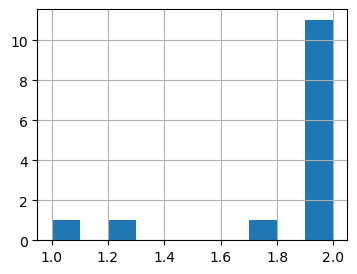

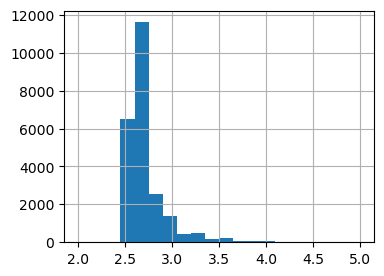

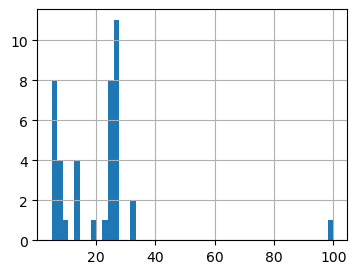

In [39]:
data['ceiling_height'].hist(bins=10, range=(1,2), figsize=(4,3));
plt.show()
data['ceiling_height'].hist(bins=20, range=(2,5), figsize=(4,3));
plt.show()
data['ceiling_height'].hist(bins=50, range=(5,100), figsize=(4,3));
plt.show()

Видим, что подавляющее большинство значений лежит в диапазоне 2.4 - 4 метра. \
С единичными ошибками при заполнении (высота менее 2.4, в диапазоне от 4 и до 24 м и более 40 м) мы ничего не сумеем сделать, так как непонятно, где именно пользователь допустил ошибку при заполнении. \
*Для диапазона значений от 24 и до 40 м сделаем предположение, что пользователь при заполнении забыл указать знак запятой и разделим указанную в df высоту потолков на 10*

In [40]:
data.loc[(data['ceiling_height'] >= 24), 'ceiling_height'] = \
data.loc[(data['ceiling_height'] >= 24), 'ceiling_height'] / 10  #  #  все высоты потолков выше 24 м уменьшаем в 10 раз

*Посчитаем число строк, в которых значения "высота потолков" выходят за границы "нормального" диапазона 2.5-4 м (т.е. "аномальны")*

In [41]:
data.query('ceiling_height < 2.5 or ceiling_height > 4')['ceiling_height'].count()

132

**Вывод**
Число строк с аномальными данными в столбце `ceiling_height` < 0,4% от общего набора, их влиянием в ходе дальнейшего анализа можно пренебречь
*Исключим строки с этими данными из общего датафрейма, после чего переустановим индекс датафрейма*

In [42]:
data = data.query('ceiling_height >= 2.5 and ceiling_height <= 4')

In [43]:
data.reset_index(drop=True, inplace= True)

*Изучим аномальные значения в столбцах `..._area`:*
1. Исходя из соображения, что (жилая площадь + площадь кухни) <= общей площади квартиры, будем искать строки, где это правило не выполняется (предполагаем ошибку при заполнении):

In [44]:
data.query('(total_area + kitchen_area) < living_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


*Таких аномалий в заполнении нет (или они были исключены на предыдущих этапах удаления строк*

2. Исходя из соображения, что, как правило, жилая площадь > площади кухни, найдём строки, где это правило не выполняется (предполагаем ошибку при заполнении):

In [45]:
data.query('living_area < kitchen_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
6,6,3700000,37.30,2017-11-02,1,2.64,26,10.60,6,False,...,14.40,1,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
51,7,45000000,161.00,2017-10-17,3,3.20,8,38.00,4,False,...,50.00,0,Санкт-Петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,541.0
53,7,4300000,39.10,2017-11-10,1,2.64,25,15.40,13,False,...,15.50,2,посёлок Парголово,52611.0,18783.0,0.0,NaN,0.0,NaN,6.0
101,4,3000000,37.00,2019-03-23,1,2.75,10,12.00,3,False,...,13.00,0,садовое товарищество Новая Ропша,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22994,12,4800000,37.00,2016-02-24,1,2.70,14,8.00,11,False,...,22.00,0,Санкт-Петербург,27838.0,12387.0,2.0,358.0,1.0,950.0,139.0
23174,7,5400000,43.00,2017-04-24,1,2.70,18,12.00,8,False,...,20.00,0,Санкт-Петербург,25108.0,15940.0,0.0,NaN,0.0,NaN,124.0
23267,1,3000000,37.29,2019-04-15,1,2.70,19,10.08,10,False,...,16.88,0,Санкт-Петербург,37006.0,15157.0,0.0,NaN,0.0,NaN,7.0
23357,8,6290000,47.67,2019-03-20,1,3.60,12,13.59,12,False,...,17.87,2,Санкт-Петербург,35726.0,16028.0,1.0,253.0,2.0,99.0,19.0


Обнаружили несколько сот строк, где, возможно, при вводе данных пользователем были перепутаны друг с другом значения в столбцах kitchen_area и living_area.\
*Но гарантировать, что это именно опечатка пользователя, а не квартира варианта планировки 2Е (1 комната + кухня-гостиная) мы не можем, поэтому не считаем эти значения аномальными, изменений не вносим*

3. При заполнении пользователи могли опечаткой увеличить/уменьшить разряд данных, проверим, есть ли в датафрейме строки, где соотношение общей и жилой площади отличаются на порядок:

In [46]:
data.query('total_area / 10 > living_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3207,7,4440000,41.0,2017-07-02,1,2.7,17,3.0,17,False,...,11.0,0,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
13780,20,6350000,52.0,2018-02-06,2,3.0,6,2.0,2,False,...,9.0,0,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
21559,0,2330000,23.0,2018-01-01,0,2.7,24,2.0,22,False,...,NaN,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
21743,15,6100000,77.6,2019-02-28,4,2.5,9,5.4,1,False,...,9.8,0,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0
23358,14,64990000,139.0,2015-11-24,3,3.0,8,3.0,8,False,...,16.0,1,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0


*Поправим данные с явно заниженным (из-за опечатки) размером жилой площади:*

In [47]:
#  правим данные в столбце `living_area` с заниженной в 10 раз жилой площадью 
data.loc[(data['living_area'] < 6) & (data['living_area'] * 10 < data['total_area']), 'living_area'] = \
data.loc[(data['living_area'] < 6) & (data['living_area'] * 10 < data['total_area']), 'living_area'] * 10

*Изучим аномальные значения в столбце `last_price`, начав со сверхдорогих предложений:*

In [48]:
data.query('last_price > 50000000').groupby('last_price')['total_area'].mean()

last_price
50788000     161.000000
51000000     264.000000
52000000     174.033333
53000000      90.000000
53250000     290.000000
                ...    
300000000    618.000000
330000000    190.000000
401300000    401.000000
420000000    900.000000
763000000    400.000000
Name: total_area, Length: 92, dtype: float64

**Выводы**

- число "сверхдорогих" (стоимость от 50 млн.руб) квартир измеряется десятками, т.е. занимает незначительную долю в общем массиве исследуемых данных
- как правило, это квартиры с большой площадью, число таких уникальных квартир и не должно быть слишком большим в датафрейме со стандартными предложениями о продаже. Поэтому данные о сверхдорогих квартирах (несмотря на возможное наличие опечаток в цене) никак корректировать не будем. При необходимости, в дальнейшем сможем отфильтровать явные аномалии, изучив сведения о стоимости квадратного метра.
- согласно данным ЦИАН, максимальная площадь продаваемого как единая квартира объекта в Санкт-Петербурге составляет ~ 940 кв.м, поэтому данные о квартирах сопоставимой площади исключать из датафрейма не будем

*Теперь посмотрим на "сверхдешёвые" квартиры:* \
Данные по Санкт-Петербургу и области лучше смотреть отдельно, примем за критерий "дешевизны" стоимость до 1 млн.руб для области и до 1,5 млн.руб для СПб)

In [49]:
data.query('last_price <= 1000000 and locality_name != "Санкт-Петербург"').groupby(['last_price']).first().head(10)

,total_images,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
last_price,,,,,,,,,,,,,,,,,,,,,
430000,5,54.0,2018-06-26,2,2.700,3,16.0,3,False,False,...,6.0,0,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
440000,18,40.0,2018-07-10,1,2.700,5,NaN,1,False,False,...,NaN,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
450000,7,42.0,2017-07-31,2,2.615,1,23.0,1,False,False,...,5.8,0,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0
470000,1,41.0,2018-02-11,1,2.700,5,32.0,3,False,False,...,9.0,0,деревня Выскатка,NaN,NaN,NaN,NaN,NaN,NaN,46.0
480000,8,32.0,2019-01-06,1,2.500,2,16.0,1,False,False,...,NaN,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,83.0
490000,6,40.0,2017-12-11,1,2.700,5,17.0,3,False,False,...,5.5,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,43.0
500000,9,30.7,2019-04-30,1,2.700,2,15.1,2,False,False,...,7.4,0,деревня Чудской Бор,NaN,NaN,NaN,NaN,NaN,NaN,110.0
520000,6,30.0,2017-09-15,1,2.500,2,18.0,1,False,False,...,5.5,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,163.0
530000,11,29.6,2019-02-20,1,2.500,5,16.0,3,False,False,...,5.8,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,27.0


**Вывод:**

- минимальная цена фигурирует в объявлениях о продаже квартир в деревнях и сёлах Ленинградской области, 
- не зная статистики и положения дел в указанных населённых пунктах сложно сделать вывод, аномальны ли эти данные (низкая цена указана только для привлечения внимания, опечатка и т.п.)
- оставим эти данные без изменений

*Теперь посмотрим на данные о min ценах по Санкт-Петербургу:*

In [50]:
data.query('last_price <= 1500000 and locality_name == "Санкт-Петербург"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
4204,8,1200000,49.1,2018-10-21,4,2.50,5,36.9,1,False,...,5.2,0,Санкт-Петербург,17539.0,12313.0,0.0,NaN,0.0,NaN,44.0
8670,1,1350000,18.8,2017-11-22,0,2.75,19,15.8,1,False,...,NaN,0,Санкт-Петербург,37636.0,14479.0,0.0,NaN,1.0,1127.0,128.0
8708,7,12190,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
17789,3,1400000,13.0,2017-12-03,1,2.60,9,NaN,1,False,...,NaN,0,Санкт-Петербург,14350.0,15945.0,0.0,NaN,1.0,185.0,410.0
19461,5,1190000,14.0,2018-07-29,1,2.70,5,11.0,1,False,...,2.0,0,Санкт-Петербург,9898.0,11122.0,0.0,NaN,0.0,NaN,4.0


**Выводы:**
- число таких квартир невелико, судя по срокам продажи, можно предположить, что низкая цена была вызвана необходимостью срочной продажи или иными,  не учитываемыми факторами
- сильно выделяется одно значение, по порядку цены видно, что при публикации цена была указана в тыс. руб. 

*Скорректируем эту цену вручную*

In [51]:
data.loc[(data['last_price'] < 20000),'last_price'] = data.loc[(data['last_price'] < 20000),'last_price'] * 1000

*Изучим аномалии в данных по жилой площади (исходя из данных https://realty.rbc.ru/ о том, что минимальная общая площадь предлагаемых в Санкт-Петербурге и области квартир составляет 18 кв.м)*

In [52]:
data.query('total_area < 18 and studio == False')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
9070,0,3400000,17.60,2018-03-18,1,2.70,5,15.00,2,False,...,NaN,0,Санкт-Петербург,21555.0,1967.0,2.0,336.0,1.0,309.0,117.0
9324,5,2100000,16.00,2017-12-10,0,2.70,6,13.00,1,False,...,NaN,0,Санкт-Петербург,20735.0,2111.0,2.0,228.0,3.0,72.0,3.0
10108,3,1900000,17.00,2018-08-14,1,2.75,4,13.00,2,False,...,3.0,0,Санкт-Петербург,25072.0,5639.0,0.0,NaN,0.0,NaN,7.0
11918,5,1900000,15.00,2018-06-27,1,2.50,5,NaN,1,False,...,NaN,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0
16787,9,1550000,15.00,2018-08-21,1,2.70,9,NaN,1,False,...,NaN,0,Санкт-Петербург,51048.0,16376.0,0.0,NaN,1.0,1079.0,42.0
17789,3,1400000,13.00,2017-12-03,1,2.60,9,NaN,1,False,...,NaN,0,Санкт-Петербург,14350.0,15945.0,0.0,NaN,1.0,185.0,410.0
19365,3,1850000,13.00,2019-03-11,1,3.40,5,NaN,2,False,...,NaN,0,Санкт-Петербург,24915.0,5483.0,1.0,644.0,0.0,NaN,24.0
19377,2,1686000,13.20,2018-12-17,1,2.70,5,NaN,1,False,...,NaN,0,Санкт-Петербург,19891.0,4165.0,1.0,361.0,1.0,155.0,19.0
19461,5,1190000,14.00,2018-07-29,1,2.70,5,11.00,1,False,...,2.0,0,Санкт-Петербург,9898.0,11122.0,0.0,NaN,0.0,NaN,4.0
19626,0,3800000,13.00,2018-07-04,1,2.70,5,10.00,3,False,...,NaN,0,Санкт-Петербург,21302.0,1242.0,1.0,592.0,3.0,27.0,9.0


Таких квартир чуть больше десятка \
*Отфильтруем в датафрейм только квартиры с полной площадью более 17 кв.м, после чего переустановим индекс*

In [53]:
data = data.query('total_area > 17 or studio == True')

In [54]:
data.reset_index(drop=True, inplace= True)

*Изучим квартиры с площадью кухни менее 4 кв.м*

In [55]:
data.query('kitchen_area < 4 and open_plan != True')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
895,15,2600000,27.00,2017-07-10,1,2.75,23,18.0,18,False,...,2.00,0,Санкт-Петербург,22131.0,17459.0,0.0,NaN,1.0,411.0,10.0
2142,15,3180000,25.00,2019-03-21,1,2.50,25,17.0,17,False,...,3.00,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,19.0
3043,17,6000000,43.00,2018-11-12,2,2.90,4,29.3,2,False,...,3.20,0,Санкт-Петербург,22357.0,5247.0,1.0,319.0,2.0,831.0,37.0
3160,17,2690000,25.60,2018-02-19,1,2.50,9,16.2,7,False,...,3.80,0,Санкт-Петербург,11033.0,11281.0,0.0,NaN,1.0,283.0,99.0
6020,6,770000,18.00,2017-10-16,1,2.60,5,13.0,4,False,...,3.00,0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,90.0
6195,9,3100000,24.00,2018-06-25,2,3.00,5,16.0,5,False,...,2.00,0,Санкт-Петербург,31960.0,4914.0,2.0,426.0,1.0,936.0,54.0
6975,9,2800000,21.00,2017-09-23,1,2.70,5,14.9,3,False,...,3.80,0,Санкт-Петербург,19676.0,3974.0,0.0,NaN,3.0,518.0,108.0
7868,3,5967734,66.40,2017-02-07,2,2.70,4,44.4,2,False,...,2.89,0,Санкт-Петербург,44870.0,20802.0,0.0,NaN,0.0,NaN,335.0
8627,6,14948000,42.70,2017-09-15,2,2.80,4,27.5,4,False,...,3.70,0,Санкт-Петербург,25212.0,3914.0,1.0,290.0,1.0,860.0,167.0
8644,9,2200000,18.40,2018-08-20,1,2.52,3,14.0,3,False,...,2.40,0,Пушкин,20710.0,30687.0,0.0,NaN,1.0,155.0,59.0


Таких квартир несколько десятков. Остальные данные (по жилой и общей площади в частности) сомнений не вызывают. И хотя столь малые размеры кухни (1.3 кв.м) аномальны, но также вполне могут быть результатом произведённой перепланировки квартир, когда оставлена лишь "кухонная ниша" \
*Оставим их в датафрейме*

*Изучим квартиры с жилой площадью менее 10 кв.м*

In [56]:
data.query('living_area < 10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
114,5,4000000,21.40,2019-02-07,1,2.90,8,8.3,7,False,...,6.3,0,Санкт-Петербург,27089.0,5791.0,2.0,488.0,1.0,286.0,NaN
669,14,7200000,43.00,2017-10-31,1,2.70,8,9.0,2,False,...,23.0,0,Санкт-Петербург,23900.0,5232.0,1.0,2137.0,1.0,933.0,296.0
1308,8,8100000,52.00,2017-01-29,2,2.70,25,9.0,15,False,...,32.0,2,Санкт-Петербург,35555.0,15561.0,0.0,NaN,1.0,1180.0,337.0
2285,10,4200000,62.40,2017-06-15,2,2.60,9,8.4,6,False,...,41.0,2,посёлок Шушары,23662.0,29448.0,0.0,NaN,0.0,NaN,111.0
4059,17,5300000,34.80,2017-06-19,1,2.70,23,9.0,15,False,...,17.1,0,Санкт-Петербург,33626.0,13495.0,0.0,NaN,0.0,NaN,30.0
4498,12,3300000,18.00,2018-11-07,1,3.50,5,9.0,2,False,...,NaN,0,Санкт-Петербург,25157.0,4948.0,2.0,349.0,1.0,963.0,9.0
7237,8,3400000,27.00,2018-02-21,2,2.50,15,9.0,4,False,...,16.0,0,Санкт-Петербург,50246.0,16444.0,1.0,617.0,0.0,NaN,NaN
8241,9,4800000,52.00,2017-10-25,2,2.70,5,9.0,2,False,...,6.0,1,Санкт-Петербург,33358.0,13171.0,0.0,NaN,2.0,118.0,119.0
15679,20,4600000,33.00,2017-01-01,1,2.70,22,9.0,12,False,...,14.3,1,Санкт-Петербург,33803.0,13671.0,0.0,NaN,0.0,NaN,511.0
16274,13,3799000,31.00,2018-04-12,1,2.60,5,6.0,1,False,...,17.0,0,Санкт-Петербург,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0


Таких квартир пара десятков. Остальные данные (по общей площади в частности) аномальными не выглядят. И хотя столь малые площади кажутся следствием опечатки и выглядят, как аномальные, но также вполне могут быть результатом произведённой перепланировки квартир, например, с модификацией 2E, упомянутой выше \
*Оставим их в датафрейме*

*Изучим квартиры, находящиеся ближе 3 км от аэропорта*

In [57]:
data.query('airports_nearest <= 3000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20884,0,7000000,34.7,2018-09-23,1,2.7,9,19.8,3,False,...,6.0,2,Санкт-Петербург,0.0,22801.0,0.0,NaN,0.0,NaN,60.0


*Такая квартира всего одна, и хотя в остальных данных аномалий не видно, но расстояние в 0 км от аэропорта явно ошибочно, можно отфильтровать сведения о ней из датафрейма*

In [58]:
data = data.query('airports_nearest != 0')

In [59]:
data.reset_index(drop=True, inplace= True)

*Изучим на аномалии данные о полном числе этажей (исходя из имеющейся в интернете информации, что максимальный по количеству этажей жилой дом в Санкт-Петербурге и области - 36-этажный)*

In [60]:
data.query('floors_total > 36')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2229,12,3800000,45.5,2018-06-28,2,2.88,60,27.4,4,False,...,7.4,0,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0
16569,9,3978000,40.0,2018-09-24,1,2.65,52,10.5,18,False,...,14.0,0,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0


Таких значений всего 2, понять, каким образом была допущена опечатка, мы не можем \
*Удалим эти значения из датафрейма*

In [61]:
data = data.query('floors_total <= 36')

In [62]:
data.reset_index(drop=True, inplace=True)

*Помотрим данные по итогам удаления аномалий*

In [63]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23468.0,9.878899e+00,5.678702e+00,0.0,6.00,9.0,1.400000e+01,50.0
last_price,23468.0,6.502853e+06,1.074488e+07,430000.0,3430000.00,4650000.0,6.790000e+06,763000000.0
total_area,23468.0,6.022767e+01,3.506025e+01,15.5,40.00,52.0,6.974250e+01,900.0
rooms,23468.0,2.068988e+00,1.076748e+00,0.0,1.00,2.0,3.000000e+00,19.0
ceiling_height,23468.0,2.701569e+00,2.094776e-01,2.5,2.55,2.7,2.700000e+00,4.0
floors_total,23468.0,1.069247e+01,6.587899e+00,1.0,5.00,9.0,1.600000e+01,36.0
living_area,21615.0,3.438443e+01,2.167182e+01,5.0,18.60,30.0,4.230000e+01,409.7
floor,23468.0,5.886271e+00,4.878982e+00,1.0,2.00,4.0,8.000000e+00,33.0
kitchen_area,21261.0,1.055695e+01,5.874734e+00,1.3,7.00,9.1,1.200000e+01,112.0
balcony,23468.0,5.927220e-01,9.597791e-01,0.0,0.00,0.0,1.000000e+00,5.0


**Выводы:**

Предварительный анализ аномалий в данных завершён:
- ряд явно аномальных значений был обнаружен и строки, содержащие такие значения (суммарно ~ 1% данных) из датафрейма были удалены
- мы убедились в том, что полностью избавиться от аномальных значений не получится в связи с неопределённостью данных, и, как следствие, невозможностью правки и при этом сомнительностью удаления (напр. очень малые min площади кухни и жилой площади)
- при этом в общем массиве датафрейма оставшиеся "возможно-аномальные" значения составляют малую часть и не должны кардинально влиять на взаимозависимости данных. 
- возможно, часть аномалий удастся "отловить" и удалить на следующем этапе, после изучения доп. параметров (цена кв. метра и т.п.)

### Изучение и обработка дубликатов

*С целью избавления от возможных дубликатов в данных, изучим столбец с наименованием населённых пунктов `locality_name`*

In [64]:
sorted(data['locality_name'].unique())

['Unknown',
 'Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское',
 'городской посёлок Янино-1',


In [65]:
# расчёт числа уникальных значений
len(data['locality_name'].unique())

364

Cреди нескольких сотен уникальных значений используются разнообразные определения для посёлков (поселок, посёлок городского типа и т.д.) и СНТ (садоводческое некоммерческое товарищество, садовое товарищество и т.д. )

*Для устранения возможных дубликатов, сперва удалим разнообразие таких наименований, оставив только названия населённых пунктов, используем для замены метод `str.replace`*

In [66]:
#  создадим словарь (для удаления значений на его основе)
pattern = ['деревня ', 'поселок ','городского типа ', 'городской', 'посёлок ', 'при железнодорожной ', 'село ',
           'станции ', 'садоводческое некоммерческое товарищество ', 'садовое товарищество ', 'коттеджный ']

#  в цикле удалим наименования типов населённых пунктов в столбце 'locality_name' и пробелы, остающиеся после удаления
for value in pattern:
    data['locality_name'] = data['locality_name'].str.replace(value, '').str.lstrip()

In [67]:
len(data['locality_name'].unique())

305

In [68]:
sorted(data['locality_name'].unique())

['Unknown',
 'Агалатово',
 'Александровская',
 'Алексеевка',
 'Аннино',
 'Аро',
 'Барышево',
 'Батово',
 'Бегуницы',
 'Белогорка',
 'Белоостров',
 'Бокситогорск',
 'Большая Вруда',
 'Большая Ижора',
 'Большая Пустомержа',
 'Большие Колпаны',
 'Большое Рейзино',
 'Большой Сабск',
 'Бор',
 'Борисова Грива',
 'Бугры',
 'Будогощь',
 'Ваганово',
 'Важины',
 'Вартемяги',
 'Вахнова Кара',
 'Вещево',
 'Виллози',
 'Вознесенье',
 'Возрождение',
 'Войсковицы',
 'Войскорово',
 'Володарское',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Вырица',
 'Выскатка',
 'Высокоключевой',
 'Высоцк',
 'Гаврилово',
 'Гарболово',
 'Гатчина',
 'Гладкое',
 'Глажево',
 'Глебычево',
 'Глинка',
 'Гончарово',
 'Горбунки',
 'Гостилицы',
 'Громово',
 'Дзержинского',
 'Дружная Горка',
 'Дружноселье',
 'Дубровка',
 'Елизаветино',
 'Ефимовский',
 'Жилгородок',
 'Жилпосёлок',
 'Житково',
 'Заводской',
 'Заклинье',
 'Заневка',
 'Запорожское',
 'Зеленогорск',
 'Зимитицы',
 'Ивангород',
 'Извара',
 'Ильичёво',
 'Иссад',


**Вывод:**
Мы привели различные наименования населённых пунктов к единообразию, очистка столбца `locality_name` от возможных дубликатов произведена (за исключением возможных опечаток в наименованиях населённых пунктов)

*Проверим предобработанный датафрейм на дубликаты, для чего создадим временный датафрейм (в котором приведём к единому (нижнему) регистру наименования населённых пунктов в столбце `locality_name`) и применим к датафрейму методы `duplicated` и `sum`*

In [69]:
data_temp = data

In [70]:
data_temp['locality_name'].str.lower()

0        санкт-петербург
1                 шушары
2        санкт-петербург
3        санкт-петербург
4        санкт-петербург
              ...       
23463    санкт-петербург
23464              тосно
23465        рождествено
23466    санкт-петербург
23467        новый учхоз
Name: locality_name, Length: 23468, dtype: object

In [71]:
data_temp.duplicated().sum()

0

*Явные дубликаты не обнаружены, на этом предварительную обработку данных можно считать завершённой*

### Добавление в таблицу доп. столбцов для исследовательского анализа

- `sqmeter_price`- цена одного квадратного метра
- `publication_week_day` - день публикации объявления (0 - monday, 1 - friday etc.)
- `publication_month` - месяц публикации объявления
- `publication_year`- год публикации объявления
- `floor_type` - тип этажа квартиры («first»(1), «other»(2), «last»(3))
- `km_to_cityCenter` - расстояние в км до центра города

In [72]:
#  формируем столбец с ценой одного квадратного метра (округлённой)
data['sqmeter_price'] = round(data['last_price'] / data['total_area'])

In [73]:
#  формируем столбец с днём недели, когда было опубликовано объявление
data['publication_week_day'] = data['first_day_exposition'].dt.weekday  

In [74]:
#  формируем столбец с номером месяца, в котором было опубликовано объявление
data['publication_month'] = data['first_day_exposition'].dt.month

In [75]:
#  формируем столбец с годом, в котором было опубликовано объявление
data['publication_year'] = data['first_day_exposition'].dt.year

In [76]:
#   для создания столбца с категорий этажа сперва зададим функцию категоризации, 
#   устанавливающую признак этажа в зависимости от его сравнения с общим числом этажей
#   для удобства построения графиков обозначим признак этажа цифрой: 1- первый, 2 - любой другой, 3 - последний

def floor_type(data_floor):
    if data_floor['floor'] == 1: return 1  
    elif data_floor['floor'] < data_floor['floors_total']: return 2
    elif data_floor['floor'] == data_floor['floors_total']: return 3

#  применим эту функцию к датафрейму, метод apply(), формируя требующийся столбец с категорией этажа

data['floor_type'] = data.apply(floor_type, axis=1)

In [77]:
#  формируем столбец с расстоянием от центра нас. пункта в км (с точностью до 1 км)
data['km_to_cityCenter'] = round(data['cityCenters_nearest'] / 1000)  

**Вывод:**
Cформированы необходимые для анализа данных о продажах дополнительные столбцы



## Исследовательский анализ данных

### Связь числа предложений и различных параметров квартиры

*При дальнейшем анализе нас будет интересовать связь между числом предложений и следующими параметрами:*
 
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления
- срок размещения объявления
- цена квадратного метра

*На гистаграммах посмотрим распределение по интересующим нас параметрам*

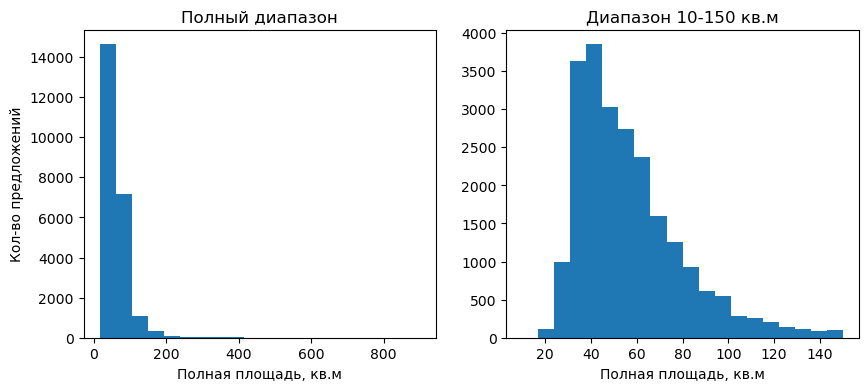

In [78]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.hist(data['total_area'],bins=20)
ax1.set(ylabel='Кол-во предложений', xlabel='Полная площадь, кв.м', title='Полный диапазон')
ax2.hist(data['total_area'], range=(10,150), bins=20)
ax2.set(xlabel='Полная площадь, кв.м', title='Диапазон 10-150 кв.м')
plt.show;

Общая площадь: подавляющее количество предложений в рассматриваемом датафрейме  -  в диапазоне 40-80 кв.м, это типичные варианты массовой застройки 1-3к квартир. Имеются также единичные предложения с площадями в несколько сотен кв.м (согласно информации в интернете, это возможно, такие квартиры на рынке СПб существуют). При дальнейшем анализе посмотрим на связь между этим параметром и ценой (полной и за кв.м)

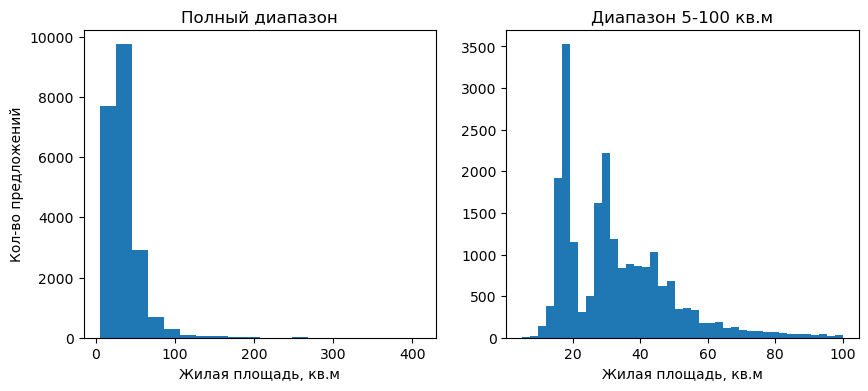

In [79]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.hist(data['living_area'],bins=20)
ax1.set(ylabel='Кол-во предложений', xlabel='Жилая площадь, кв.м', title='Полный диапазон')
ax2.hist(data['living_area'], range=(5,100), bins=40)
ax2.set(xlabel='Жилая площадь, кв.м', title='Диапазон 5-100 кв.м')
plt.show;

Жилая площадь: подавляющее количество предложений - в диапазоне 15-35 кв. метров, это типичные варианты массовой застройки 1-3к квартир, с яркими пиками на 18 кв.м (площадь одной комнаты) и 35 кв.м (площадь двух комнат). Имеются также единичные предложения с площадями в несколько сот кв.м. При дальнейшем анализе посмотрим на связь между этим параметром и ценой (полной и за кв.м)

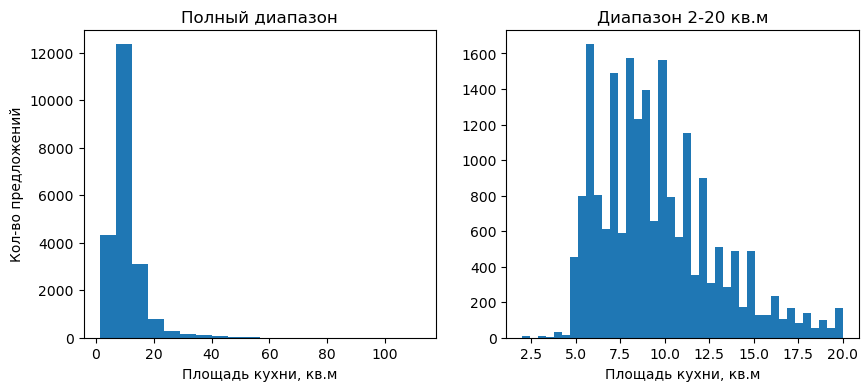

In [80]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.hist(data['kitchen_area'],bins=20)
ax1.set(ylabel='Кол-во предложений', xlabel='Площадь кухни, кв.м', title='Полный диапазон')
ax2.hist(data['kitchen_area'], range=(2,20), bins=40)
ax2.set(xlabel='Площадь кухни, кв.м', title='Диапазон 2-20 кв.м')
plt.show;

Площадь кухни: подавляющее количество предложений - в диапазоне 6-12 кв.м, это типовой вариант для основного, представленного в датафрейме масссива 1-3 комнатных квартир. Есть несколько сотен вариантов с заметно большими размерами кухни (и единичные - с сотнями кв. метров), возможно - результат перепланировки и уникальные предложения, соответствующие квартирам с чрезвычайно большой общей площадью. При дальнейшем анализе посмотрим на связь между этим параметром и ценой (полной и за кв.м)

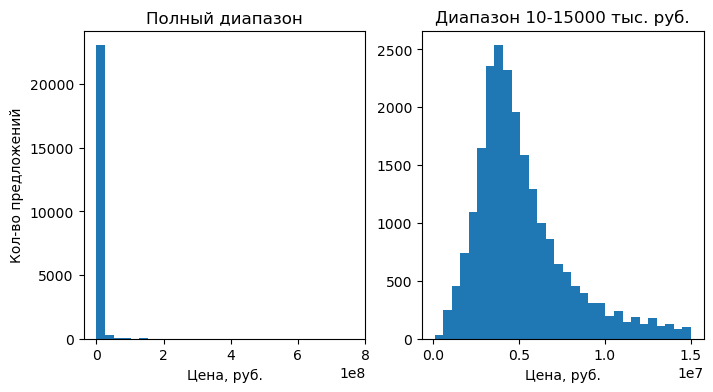

In [81]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.hist(data['last_price'],bins=30)
ax1.set(ylabel='Кол-во предложений', xlabel='Цена, руб.', title='Полный диапазон')
ax2.hist(data['last_price'], range=(100000,15000000), bins=30)
ax2.set(xlabel='Цена, руб.', title='Диапазон 10-15000 тыс. руб.')
plt.show;

Цена объекта: основная часть предложений - в ценовом сегменте до 10 млн. руб), его имеет смысл рассмотреть подробнее, хотя есть и эксклюзивные предложения, с ценой в несколько сотен млн.руб. Далее в анализе оценим влияние различных параметров квартиры на её полную цену.

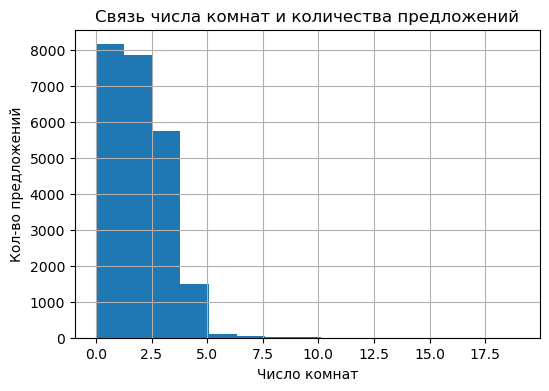

In [82]:
data['rooms'].hist(bins=15, figsize=(6,4)).set(ylabel='Кол-во предложений', xlabel='Число комнат', 
                                               title='Связь числа комнат и количества предложений')
plt.show;

Число комнат: основной массив предложений, как и можно было предположить из анализа площадей квартир - это 1-3 к. квартиры + небольшое количество уникальных предложений, с числом комнат до 19. Далее проанализируем взаимосвязь между числом комнат и ценой квартиры (полной и за кв.м)

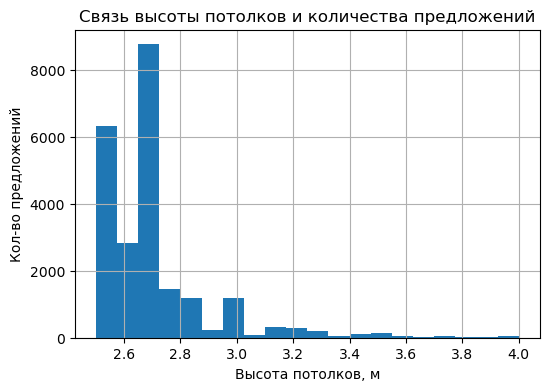

In [83]:
data['ceiling_height'].hist(bins=20, figsize=(6,4)).set(ylabel='Кол-во предложений', xlabel='Высота потолков, м',
                                                       title='Связь высоты потолков и количества предложений')
plt.show;

Высота потолков: этот столбец был на этапе предобработки "нормализован", в нём не осталось аномальных значений, большинство квартир вписывается в "стандартные" высоты 2,4-2.8 метра, с явными пиками на высотах 2,5 и 2,7 м, характерными для типовой советской застройки. Несколько сот предложений большей высоты - это могут быть как квартиры в дореволюционном жилом фонде, так и новые, сделаные по специальным проектам, квартиры

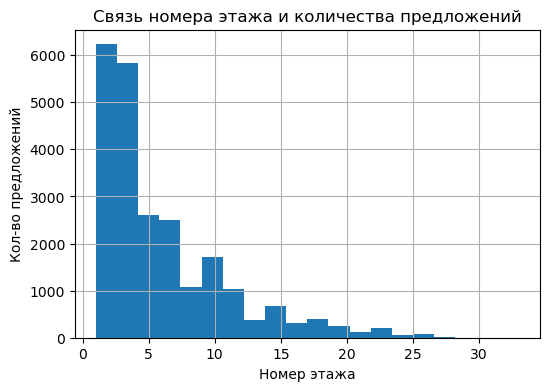

In [84]:
data['floor'].hist(bins=20, figsize=(6,4)).set(ylabel='Кол-во предложений', xlabel='Номер этажа',
                                              title='Связь номера этажа и количества предложений')
plt.show;

Этаж квартиры: основная часть предложений - на "невысоких", до 10го, этажах, более половины - на этажах до 5го включительно (что отражает состояние жилого фонда в Санкт-Петербурге, где высотное строительство началось сравнительно недавно и на момент формирования датафрейма не существовало массового предложения о продаже в высотных жилых комплексах)

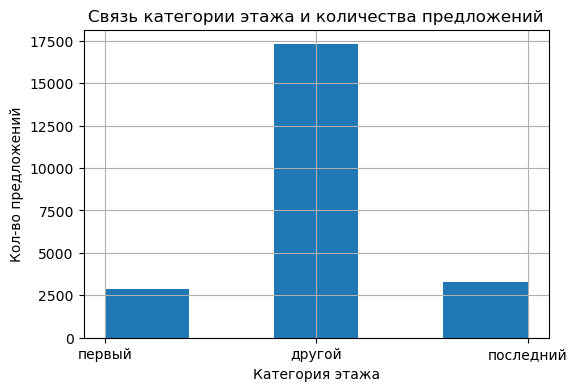

In [85]:
data['floor_type'].hist(bins=5, figsize=(6,4)).set(ylabel='Кол-во предложений', xlabel='Категория этажа',
                                                  title='Связь категории этажа и количества предложений')
plt.xticks([1,2,3], ['первый', 'другой', 'последний'])
plt.show()

Тип этажа квартиры («первый», «последний», «другой»): значительное число предложений по продаже - на "некрайнем" этаже, хотя "первый" + "последний" этажи также составляют порядка четверти от всех предложений, в дальнейшем анализе посмотрим взаимосвязь между "категорией" этажа и полной стоимостью / ценой за кв. м.

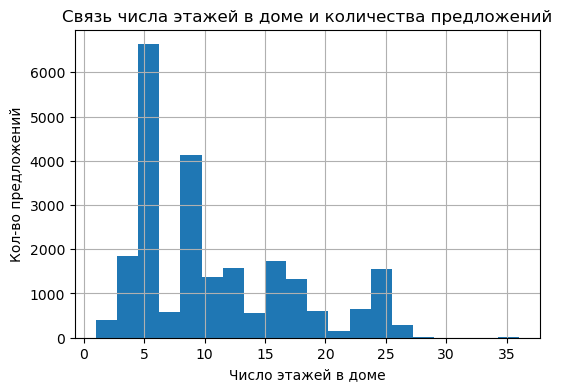

In [86]:
data['floors_total'].hist(bins=20, figsize=(6,4)).set(ylabel='Кол-во предложений', xlabel='Число этажей в доме',
                                                     title='Связь числа этажей в доме и количества предложений')
plt.show()

Общее количество этажей в доме: основной массив объявлений - в домах низкой этажности (до 10), с характерными пиками на 5 и 9 этажах, есть локальные пики, указывающие на предложения в высотках

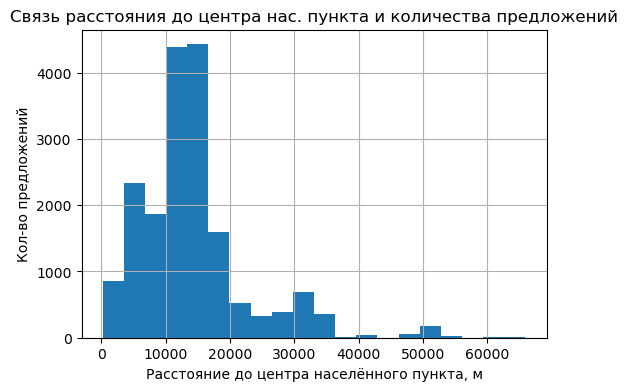

In [87]:
data['cityCenters_nearest'].hist(bins=20, figsize=(6,4)).set(ylabel='Кол-во предложений', 
                            xlabel='Расстояние до центра населённого пункта, м',
                            title='Связь расстояния до центра нас. пункта и количества предложений')
plt.show()

(для трёх следующих столбцов при оценке данных надо помнить что около четверти значений в датафрейме отсутствует из-за возможных ошибок при переносе данных или отсутствия картографической информации о населённом пункте):

Расстояние до центра города в метрах: основной массив квартир расположен в пределах 20 км от центра города (что явно характерно для самого Санкт_Петербурга). Далее проанализируем зависимость ценовых параметров квартир от удаления от центра.

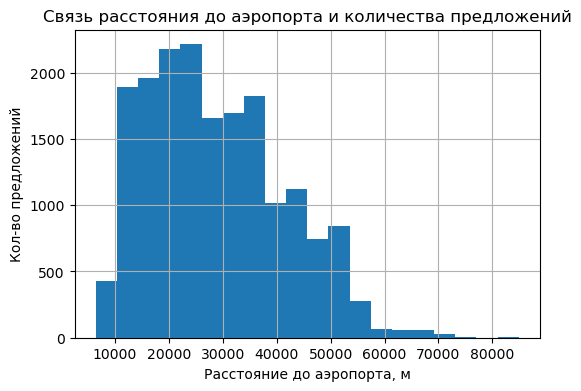

In [88]:
data['airports_nearest'].hist(bins=20, figsize=(6,4)).set(ylabel='Кол-во предложений', xlabel='Расстояние до аэропорта, м',
                                                         title='Связь расстояния до аэропорта и количества предложений')
plt.show()

Расстояние до ближайшего аэропорта: основная часть предлагаемых квартир расположена равномерно в диапазоне 10-35 км. от аэропорта "Пулково", что соответствует общему условию - 3/4 квартир в датафрейме из Санкт-Петербурга

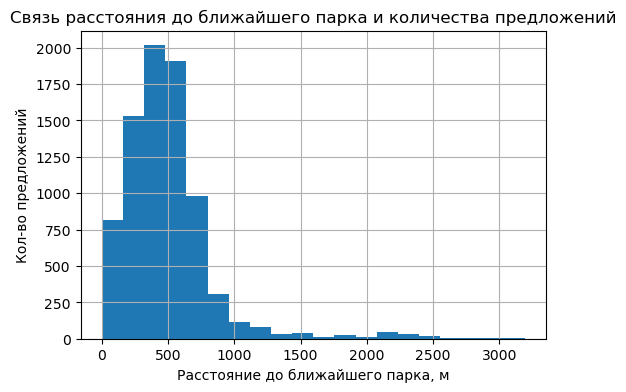

In [89]:
data['parks_nearest'].hist(bins=20, figsize=(6,4)).set(ylabel='Кол-во предложений',
                                                       xlabel='Расстояние до ближайшего парка, м',
                                                      title='Связь расстояния до ближайшего парка и количества предложений')
plt.show()

Расстояние до ближайшего парка: хорошо виден пик (близкого к нормальному) распределения на отметке ~ 500м. Зелёные насаждения распространены и доступны в СПб и большей части ЛО

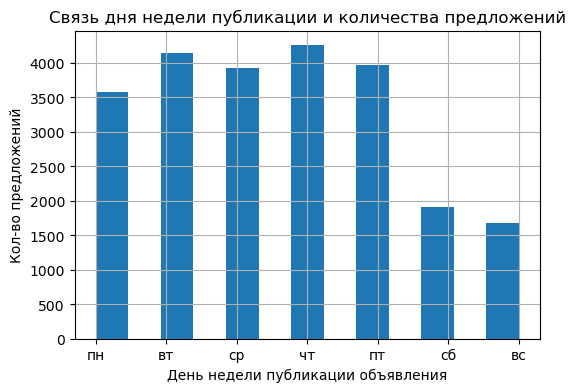

In [90]:
data['publication_week_day'].hist(bins=13, figsize=(6,4)).set(ylabel='Кол-во предложений',
                                                              xlabel='День недели публикации объявления',
                                                             title='Связь дня недели публикации и количества предложений')
plt.xticks([0,1,2,3,4,5,6], ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
plt.show()

День публикации объявления: публикации распределены равномерно по рабочим дням, и их число заметно сокращается в выходные дни. Дальше в анализе проследим, связан ли день публикации объявления с стоимостными параметрами

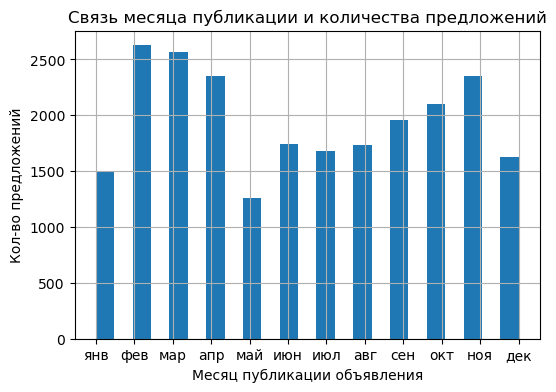

In [91]:
data['publication_month'].hist(bins=23, figsize=(6,4)).set(ylabel='Кол-во предложений', xlabel='Месяц публикации объявления',
                                                          title='Связь месяца публикации и количества предложений')
plt.xticks(range(1,13), ['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек'])
plt.show()

Месяц публикации: пик приходится на весенние и осенние месяцы, в то время как летом и в пред/посленовогодний период количество публикуемых объявлений сокращается. Далее проверим при анализе, есть ли корреляция между днём/месяцем публикации и сроком продажи квартиры (числом дней экспозиции), а также стоимостными параметрами

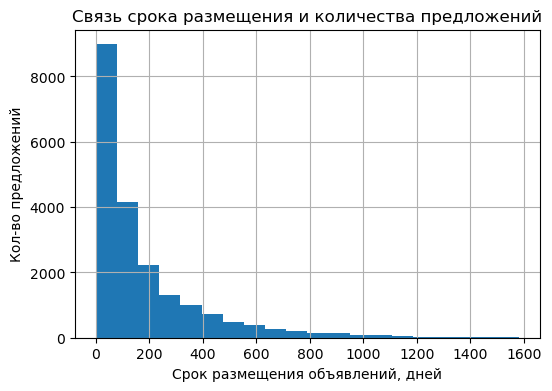

In [92]:
data['days_exposition'].hist(bins=20, figsize=(6,4)).set(ylabel='Кол-во предложений', 
                                                         xlabel='Срок размещения объявлений, дней',
                                                        title='Связь срока размещения и количества предложений')
plt.show()

Срок размещения объявления: можно видеть, что квартиры продавались (или снимались с продажи) в массе своей в пределах 150 дней, что может быть связано с различными параметрами, в том числе и условиями публикации объявлений. Хоте некоторые предложения сохранялись в базе весь период (11.2014-05.2019)

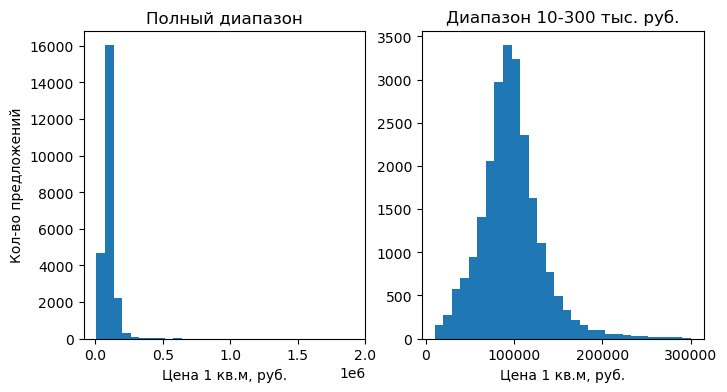

In [93]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.hist(data['sqmeter_price'],bins=30)
ax1.set(ylabel='Кол-во предложений', xlabel='Цена 1 кв.м, руб.', title='Полный диапазон')
ax2.hist(data['sqmeter_price'], range=(10000,300000), bins=30)
ax2.set(xlabel='Цена 1 кв.м, руб.', title='Диапазон 10-300 тыс. руб.')
plt.show()

Цена 1 кв.м.: достаточно ожидаемое нормальное распределение этого параметра с пиком в районе 90-100 тыс.р. (и "хвост" из очень дорогих уникальных предложений)

*Изучим показатель `days_exposition`, указывающий на СРОК ПРОДАЖИ КВАРТИРЫ*

In [94]:
data['days_exposition'].describe().T

count    20315.000000
mean       180.780950
std        219.605257
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

*Построим гистаграммы и  boxplot по всему диапазону значений и в пределах (mean + std)*

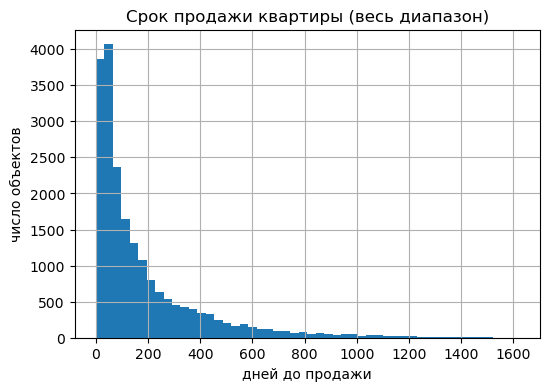

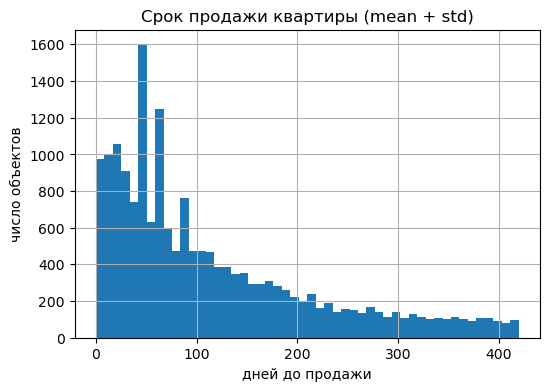

In [95]:
data['days_exposition'].hist(bins=50, range=(0,1620), figsize=(6,4)).set(title='Срок продажи квартиры (весь диапазон)', 
    xlabel='дней до продажи', ylabel='число объектов');
plt.show()
data['days_exposition'].hist(bins=50, range=(0,420), figsize=(6,4)).set(title='Срок продажи квартиры (mean + std)', 
    xlabel='дней до продажи', ylabel='число объектов');
plt.show()

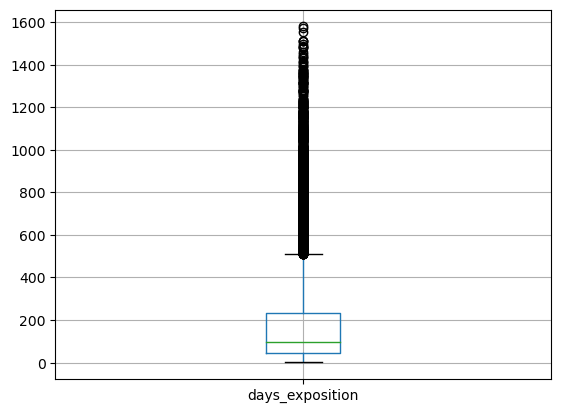

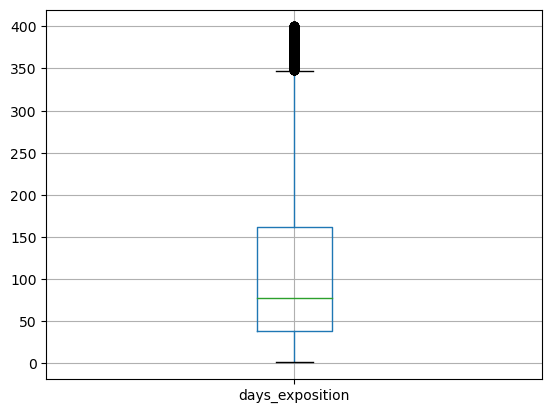

In [96]:
data.boxplot(column='days_exposition');
plt.show()
data.query('days_exposition < (days_exposition.mean() + days_exposition.std())').boxplot(column='days_exposition');
plt.show()

**Вывод:** 
большинство квартир в изучаемом датафрейме продалось в течение первого года, при этом видны заметные пики на ~45 и ~60 днях (возможно, связанных со стандартными периодами оформления продаж наиболее удачных предложений), что и привело к медианному значению срока продажи в 94 дня, почти в 2 раза отличающемуся от среднего значения, которое учитывает выбросы, с временем продажи в сроки от года и выше (до 5 лет!) \
Исходя из этих наблюдений, можно заключить, что "БЫСТРОЙ" можно счесть продажу квартиры в период до 3 месяцев, "МЕДЛЕННОЙ" - занявшей больше года*

### Связь стоимости/цены 1 кв.м и различных параметров квартиры

**ЧИСЛО КОМНАТ (`rooms`):**

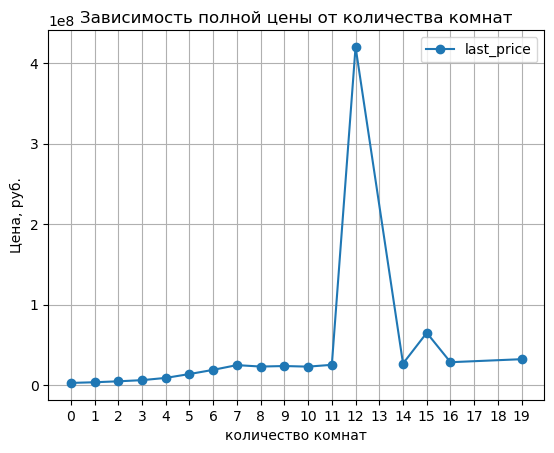

In [97]:
data.pivot_table(index='rooms', values='last_price', aggfunc='median').reset_index(). \
            plot(x='rooms', y='last_price', grid=True, style='o-', title='Зависимость полной цены от количества комнат', 
            xlabel='количество комнат', ylabel='Цена, руб.', xticks=(range(20))
            );

**Выводы:**
- заметен ожидаемый (близкий к линейному) рост стоимости в зависимости от числа комнат/общей площади (этот параметр изучим внимательней позже)
- заметны экстремальные выбросы стоимости для квартир с 12 и 15 комнатами (несколько эксклюзивных предложений на рынке). 
- ранее на гистограмме распределения предложений по числу комнат видели, что основной массив предложений составляют квартиры с числом комнат до 5, изучим этот интервал подробнее \
Также здесь (и при будущем анализе) включим в исследование зависимости от параметра не только полной цены (стоимости) квартиры, но и цены 1 кв.м (`sqmeter_price`)

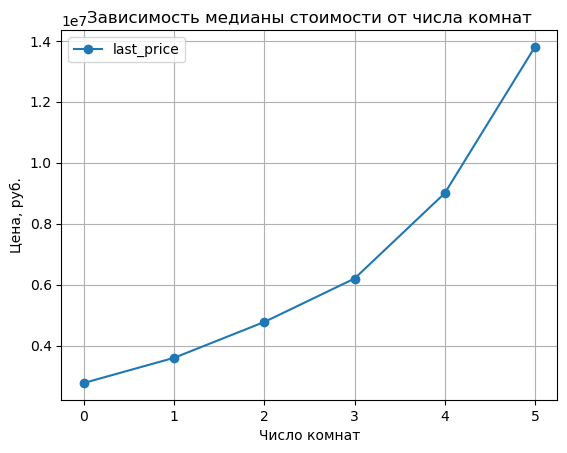

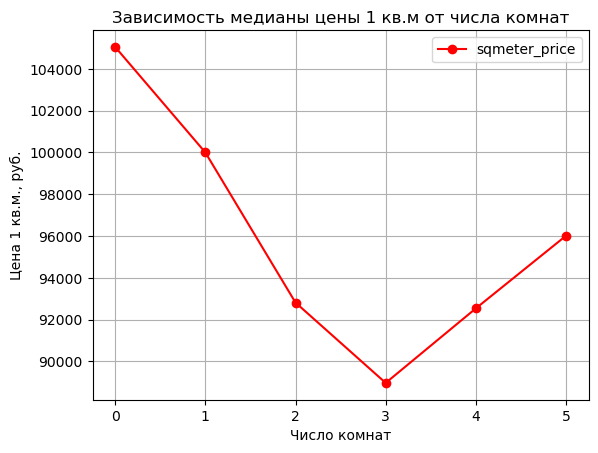

In [98]:
data.query('rooms <= 5').pivot_table(index='rooms', values='last_price', aggfunc='median').reset_index(). \
                plot(x='rooms', y='last_price', grid=True, style='o-',
                 title='Зависимость медианы стоимости от числа комнат', 
                 xlabel='Число комнат', ylabel='Цена, руб.'
                );
plt.show()

data.query('rooms <= 5').pivot_table(index='rooms', values='sqmeter_price', aggfunc='median').reset_index(). \
                plot(x='rooms', y='sqmeter_price', grid=True, style='o-', color='red',
                 title='Зависимость медианы цены 1 кв.м от числа комнат', 
                 xlabel='Число комнат', ylabel='Цена 1 кв.м., руб.'
                );
plt.show()

**Выводы:**
- наблюдаем рост стоимости квартир по мере увеличения числа комнат, по виду зависимость похожа на квадратичную
- стоимость 1 кв. метра максимальна для студий и 1-к квартир, затем существенно (на 8 и 10% соответственно) снижается для 2-3к. квартир, и снова подрастает для 4 и 5к. квартир

**ОБЩАЯ ПЛОЩАДЬ, ЖИЛАЯ ПЛОЩАДЬ, ПЛОЩАДЬ КУХНИ (`total_area`, `living_area`, `kitchen_area`)**  \
(при построении будем изучать диапазон до 99 процентиля, отсекая выбросы вверх (продажи сверхбольших квартир):

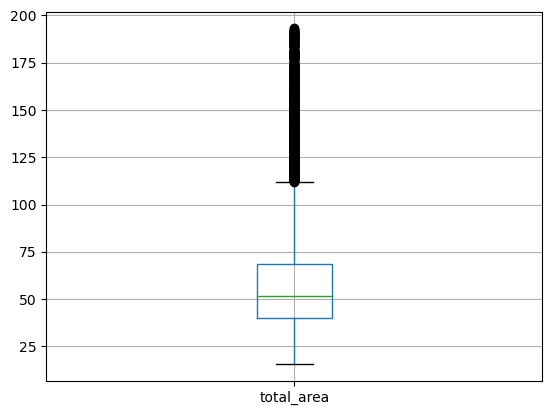

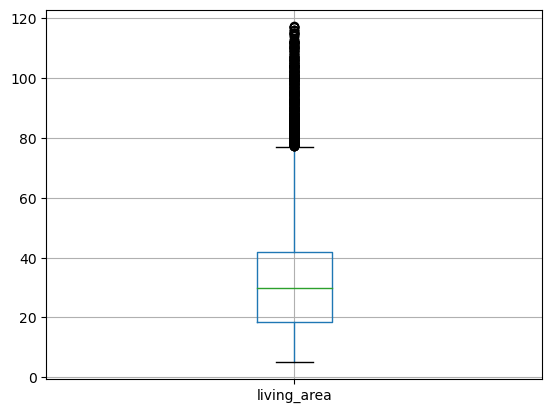

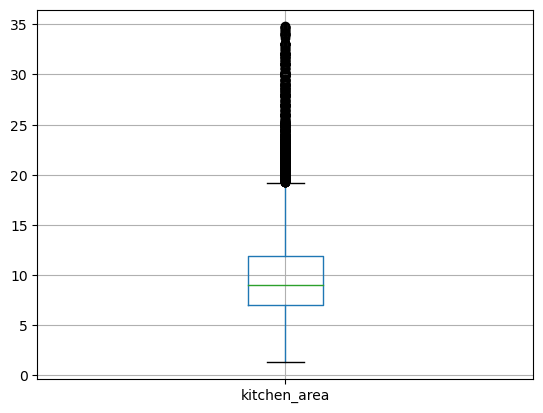

In [99]:
data.query('total_area < total_area.quantile(0.99)').boxplot(column='total_area');
plt.show()
data.query('living_area < living_area.quantile(0.99)').boxplot(column='living_area');
plt.show()
data.query('kitchen_area < kitchen_area.quantile(0.99)').boxplot(column='kitchen_area');

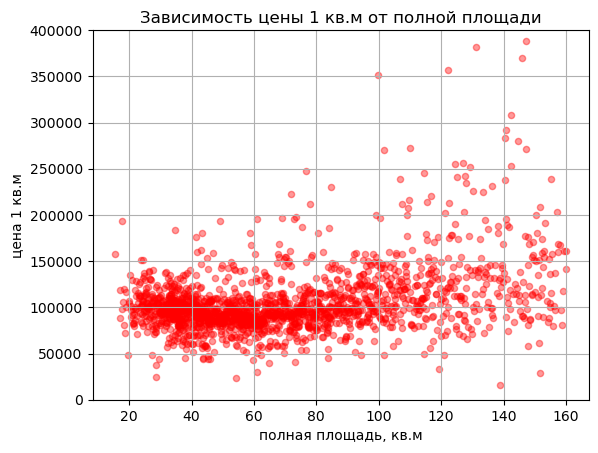

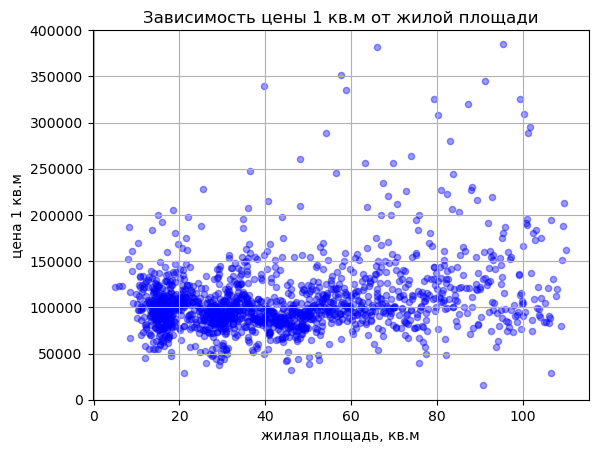

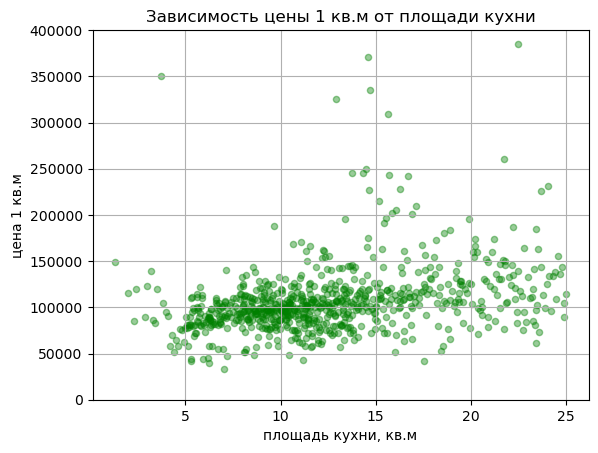

In [100]:
data.query('total_area <= 160').pivot_table(index='total_area', values='sqmeter_price', aggfunc='median').reset_index(). \
                plot(x='total_area', y='sqmeter_price', grid=True, kind='scatter', alpha=0.4, c='red'). \
                set(title='Зависимость цены 1 кв.м от полной площади', xlabel='полная площадь, кв.м', ylabel='цена 1 кв.м')
plt.ylim([0, 400000])
plt.show();

data.query('living_area <= 110').pivot_table(index='living_area', values='sqmeter_price', aggfunc='median').reset_index(). \
                plot(x='living_area', y='sqmeter_price', grid=True, kind='scatter', alpha=0.4, c='blue'). \
                set(title='Зависимость цены 1 кв.м от жилой площади', xlabel='жилая площадь, кв.м', ylabel='цена 1 кв.м')
plt.ylim([0, 400000])
plt.show();

data.query('kitchen_area <= 25').pivot_table(index='kitchen_area', values='sqmeter_price', aggfunc='median').reset_index(). \
                plot(x='kitchen_area', y='sqmeter_price', grid=True, kind='scatter', alpha=0.4, c='green'). \
                set(title='Зависимость цены 1 кв.м от площади кухни', xlabel='площадь кухни, кв.м', ylabel='цена 1 кв.м')
plt.ylim([0, 400000])
plt.show();

**Выводы:**
- существуют выраженные диапазоны, в которых цена за 1 кв. м. стабильна, колеблется в районе 100 тыс. руб. за 1 кв. м и мало подвержена выбросам: для общей площади это 20-100м. кв., для жилой - 10-75 кв. м, для площади кухни - 5 - 15 кв. м.
- при выходе площади за верхний предел указанных диапазонов нарастает разброс цен (в сторону увеличения)

*Проверим это утверждение, посмотрим таблицу взаимной корреляции и построим матрицу диаграмм рассеяния для тех же площадей и полной цены)*

In [101]:
data_square = data[['last_price', 'total_area', 'living_area', 'kitchen_area']]. \
    query('total_area < 175 and living_area < 120 and kitchen_area < 35')
data_square.corr()

,last_price,total_area,living_area,kitchen_area
last_price,1.000000,0.712901,0.611271,0.510412
total_area,0.712901,1.000000,0.930560,0.540631
living_area,0.611271,0.930560,1.000000,0.308373
kitchen_area,0.510412,0.540631,0.308373,1.000000


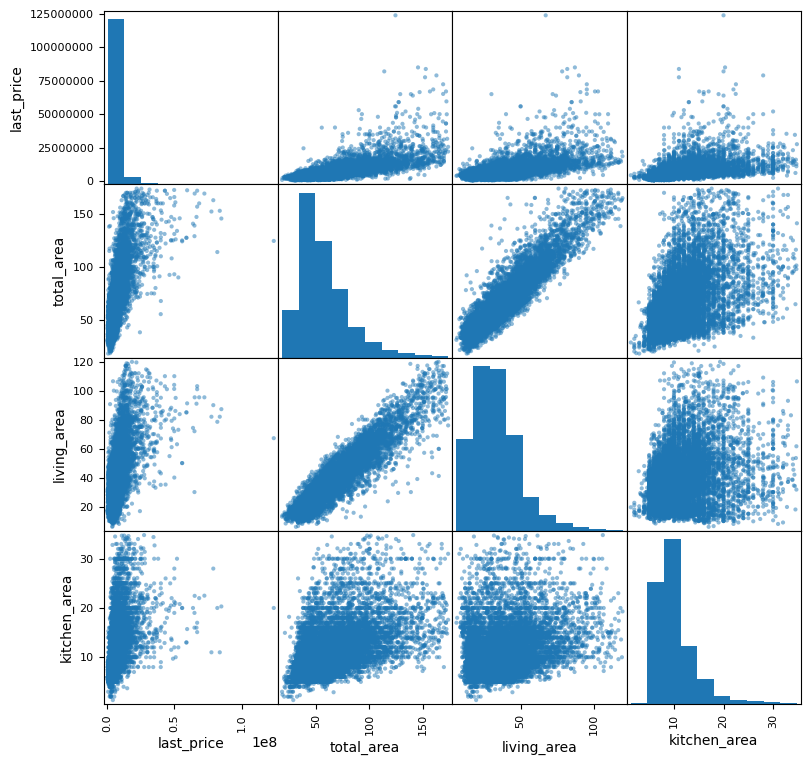

In [102]:
pd.plotting.scatter_matrix(data_square, figsize=(9, 9));

**Выводы:**
- практически отсутствует (кажущаяся очевидной по умолчанию) прямая коррелция между площадью кухни и полной/жилой площадью. Это может быть вызвано неаккуратностью в заполнении пункта пользователями, а также тем, что, по мере роста размера квартиры, площадь кухни варьирует в широком диапазоне
- явной корреляции между ценой квартиры и каждым из факторов по отдельности (полная, жилая и площадь кухни) не отмечается
- вероятно, помимо площади на стоимость квартиры влияют и иные факторы, включая расстояние от центра, этажность, день, месяц и год размещения.

**ТИП ЭТАЖА (`floor_type`)**

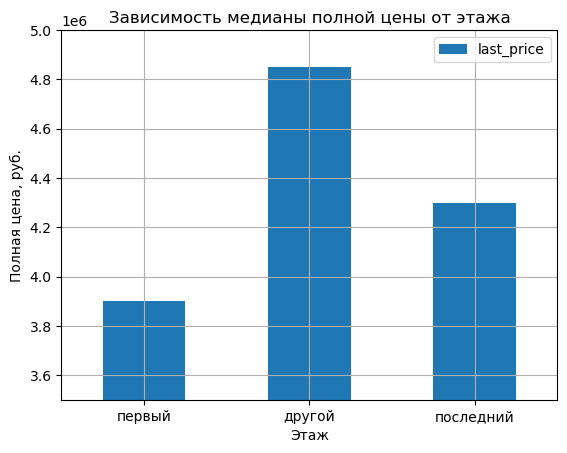

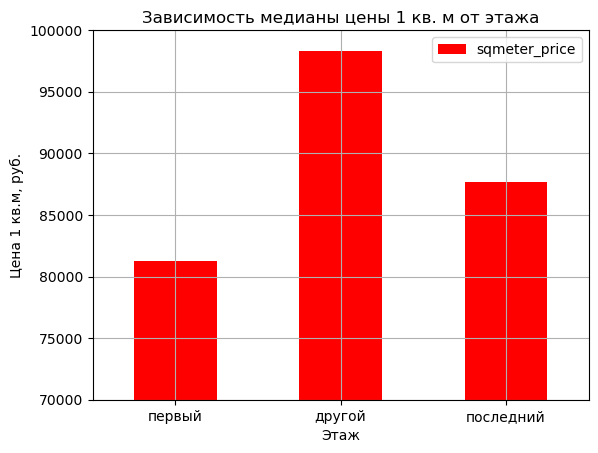

In [103]:
data.pivot_table(index='floor_type', values='last_price', aggfunc='median').reset_index(). \
                    plot(kind = 'bar', x='floor_type', y='last_price', grid = True,
                     xlabel='Этаж', ylabel='Полная цена, руб.',
                     title='Зависимость медианы полной цены от этажа'
                    )
plt.xticks([0,1,2], ['первый', 'другой', 'последний'],rotation=0)
plt.ylim([3500000, 5000000])
plt.show()

data.pivot_table(index='floor_type', values='sqmeter_price', aggfunc='median').reset_index(). \
                plot(x='floor_type', y='sqmeter_price', kind = 'bar', grid = True,
                 xlabel='Этаж', ylabel='Цена 1 кв.м, руб.', color='red',
                 title='Зависимость медианы цены 1 кв. м от этажа'
                     )
plt.ylim([70000, 100000])
plt.xticks([0,1,2], ['первый', 'другой', 'последний'],rotation=0)
plt.show()

**Выводы:**
- в квартирах на первом этаже цена 1 кв.м существенно (~ 5-15%!) ниже цены 1 кв.м для квартир на любом другом этаже (возможные причины - шум, загазованность, сравнительно большой риск ограбления и т.п.)
- квартиры на последнем этаже также "теряют" в стоимости по сравнению с квартирами на "других" этажах (возможные причины - отсутствие лифта, протечки, больший риск ограбления и т.п.)

**ГОД РАЗМЕЩЕНИЯ (`publication_year`)**

*Изучим с помощью диаграмм размаха, как полная цена и цена 1 кв.м менялась на протяжении нескольких лет (для 99% значений, исключая эксклюзивные, самые дорогие предложения*

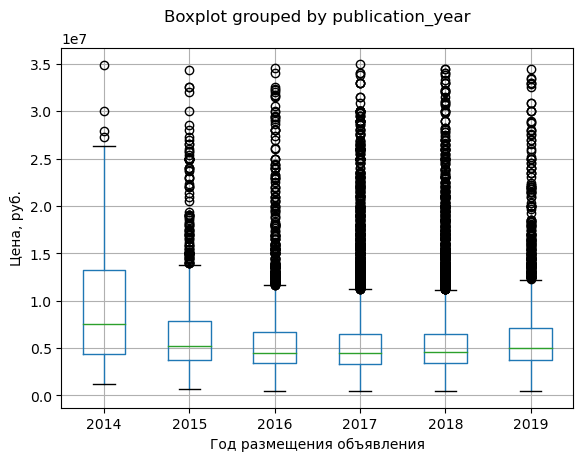

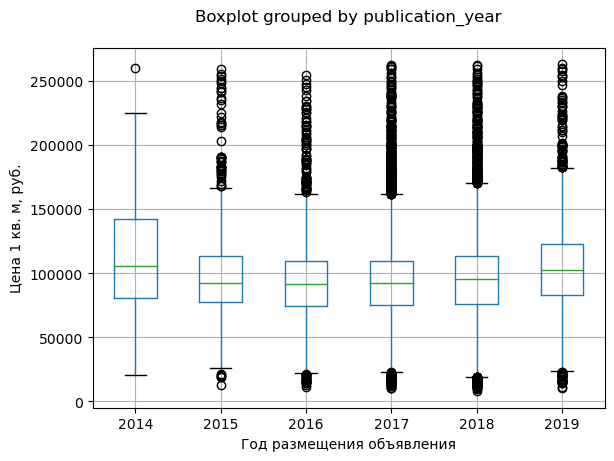

In [104]:
data.query('last_price < last_price.quantile(0.99)').boxplot(column='last_price', by='publication_year'). \
 set(xlabel='Год размещения объявления', ylabel='Цена, руб.', title="");
plt.show()
data.query('sqmeter_price < sqmeter_price.quantile(0.99)').boxplot(column='sqmeter_price', by='publication_year'). \
 set(xlabel='Год размещения объявления', ylabel='Цена 1 кв. м, руб.', title="");

**Выводы:**
- в 2014 году рынок был стабильнее, с меньшим числом ценовых выбросов (далее надо исследовать его объём, это может быть сопряжено в том числе с малым числом предложений)
- характерное понижение цены 1 кв. метра и полной цены с 2014 заметно на протяжении нескольких лет

*Для наглядности построим графики зависимости медианных значений стоимости и цены 1 кв. м по годам продаж*

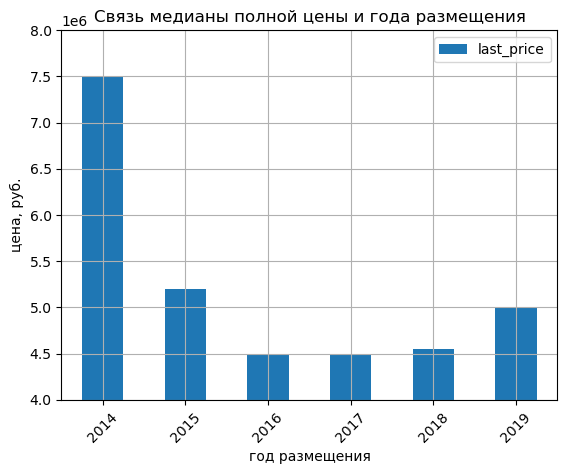

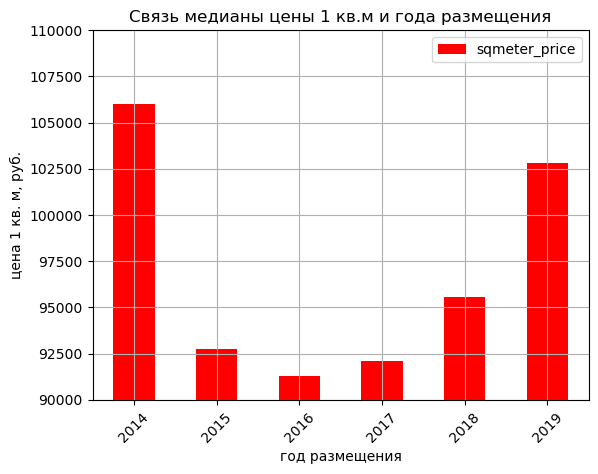

In [105]:
data.query('last_price < last_price.quantile(0.99)'). \
            pivot_table(index='publication_year', values='last_price', aggfunc='median').reset_index(). \
            plot(x='publication_year', y='last_price', grid=True, kind='bar',
                 title='Связь медианы полной цены и года размещения', 
                 xlabel='год размещения', ylabel='цена, руб.'
                )
plt.xticks(rotation=45)
plt.ylim([4000000, 8000000])
plt.show();

data.query('sqmeter_price < sqmeter_price.quantile(0.99)'). \
            pivot_table(index='publication_year', values='sqmeter_price', aggfunc='median').reset_index(). \
            plot(x='publication_year', y='sqmeter_price', grid=True, kind='bar', color='red',
                 title='Связь медианы цены 1 кв.м и года размещения', 
                 xlabel='год размещения', ylabel='цена 1 кв. м, руб.'
                )
plt.ylim([90000, 110000])
plt.xticks(rotation=45)
plt.show();

**Вывод:**
- отчётливо наблюдается провал рынка продаж недвижимости в 2015-2017 годах, восстановление началось только с 2018 года
- медианная цена 1 кв.м восстанавливалась быстрее, чем медиана полной цены

*Дополнительно изучим динамику продаж квартир по годам*

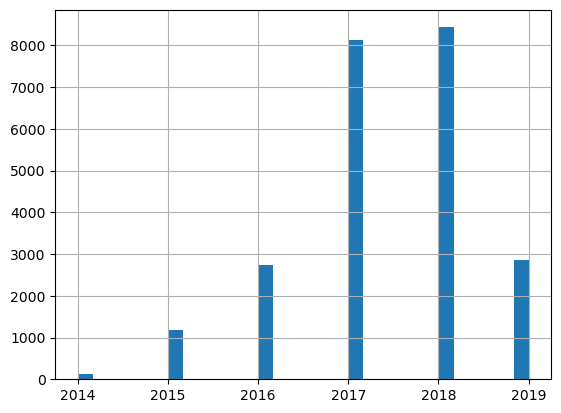

In [106]:
data['publication_year'].hist(bins=30);

**Вывод:**
- предполагаемая "устойчивость" рынка в 2014 году объясняется в основном малым числом предложений в датафрейме
- наблюдается устойчивый рост числа предложений на протяжении нескольких лет, с 2014 по 2018 включительно, нексмотря даже на "ценовой кризис" 2015-2017 годов
- данные за 2019 год представлены не полностью, исходя из восстановления цены на докризисном уровне можно предположить, что по итогам 2019 года число предложений о продаже может превысить аналогичное в 2018

**ДЕНЬ И МЕСЯЦ РАЗМЕЩЕНИЯ (`publication_week_day`, `publication_month`)**

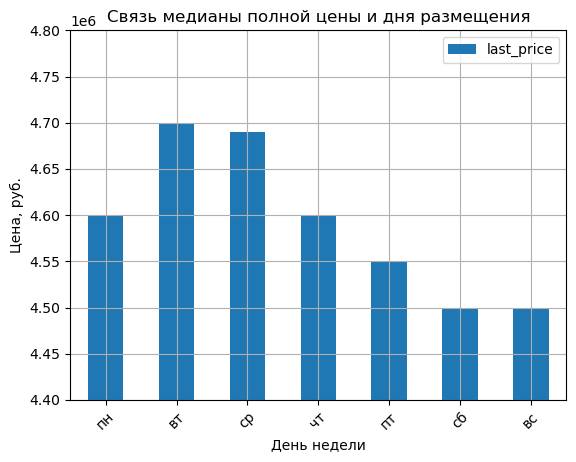

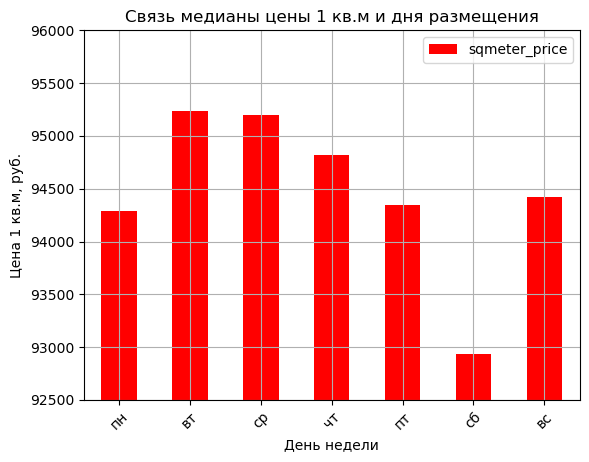

In [107]:
data.query('last_price < last_price.quantile(0.99)'). \
            pivot_table(index='publication_week_day', values='last_price', aggfunc='median').reset_index(). \
            plot(x='publication_week_day', y='last_price', grid=True, kind='bar', 
                 title='Связь медианы полной цены и дня размещения', 
                 xlabel='День недели', ylabel='Цена, руб.'
                );
plt.xticks([0,1,2,3,4,5,6], ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'], rotation=45)
plt.ylim([4400000, 4800000])
plt.show()

data.query('sqmeter_price < sqmeter_price.quantile(0.99)'). \
            pivot_table(index='publication_week_day', values='sqmeter_price', aggfunc='median').reset_index(). \
            plot(x='publication_week_day', y='sqmeter_price', grid=True, kind='bar', color='red',
                 title='Связь медианы цены 1 кв.м и дня размещения', 
                 xlabel='День недели', ylabel='Цена 1 кв.м, руб.'
                );
plt.ylim([92500, 96000])
plt.xticks([0,1,2,3,4,5,6], ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'], rotation=45)
plt.show()

**Вывод:**
- при сопоставимом числе размещений в будние дни, лучшие показатели цены (полной и 1 кв.м) - для объявлений во вторник и среду
- размещаемые в выходные дни (особенно в субботу) объявления по медиане - менее "дорогие"
- разница цены 1 кв.м между "лучшим и "худшим" днями ~ 3%, полной цены ~ 4%

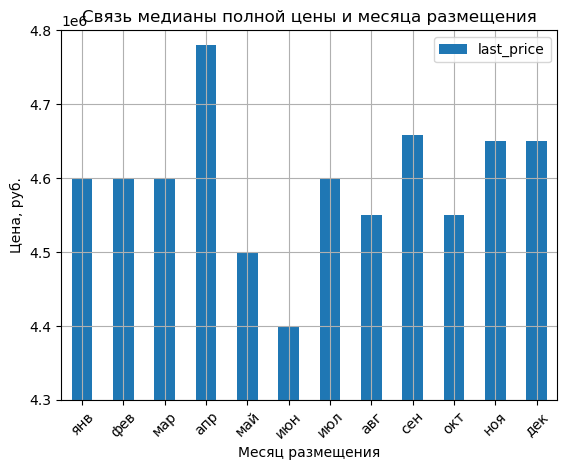

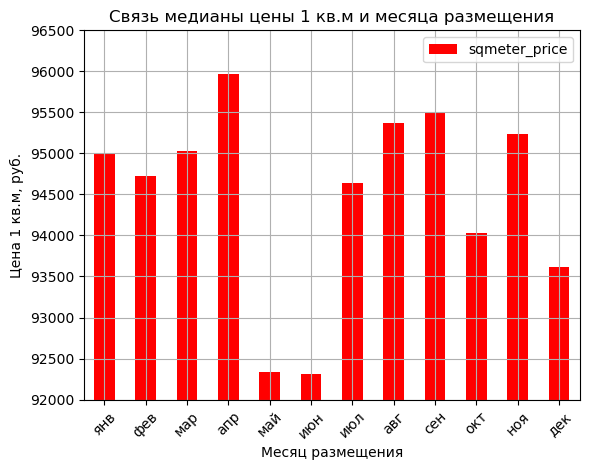

In [108]:
data.query('last_price < last_price.quantile(0.99)'). \
pivot_table(index='publication_month', values='last_price', aggfunc='median').reset_index(). \
            plot(x='publication_month', y='last_price', grid=True, kind='bar',
                 title='Связь медианы полной цены и месяца размещения', 
                 xlabel='Месяц размещения', ylabel='Цена, руб.'
                );
plt.xticks(range(12), ['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек'], rotation = 45)
plt.ylim(4300000, 4800000)
plt.show()
data.query('sqmeter_price < sqmeter_price.quantile(0.99)'). \
pivot_table(index='publication_month', values='sqmeter_price', aggfunc='median').reset_index(). \
            plot(x='publication_month', y='sqmeter_price', grid=True, kind='bar', color='red',
                 title='Связь медианы цены 1 кв.м и месяца размещения', 
                 xlabel='Месяц размещения', ylabel='Цена 1 кв.м, руб.'
                );
plt.ylim(92000, 96500)
plt.xticks(range(12), ['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек'], rotation = 45)
plt.show()

**Вывод:**
- в мае размещается меньше всего объявлений, а в июне, хотя число объявлений и растёт, но размещение идёт с минимальной (по медиане) ценой, как полной, так и 1 кв.м.
- лучший с т.з. размещения месяц - апрель: в топ-3 по числу объявлений и 1 место по медианной цене размещения
- видна чёткая сезонность в размещении - "высокий сезон" февраль-апрель и осень, "низкий сезон" - май-июль и околоновогодние месяцы
- размах цен между "высоким" и "низким" сезонами - в диапазоне от 2,5-3% (цена за 1 кв.м) до 6-8% (полная цена)
- возможно, в "высокий сезон" стараются выставлять на рынок квартиры большей, чем в "низкий" площади

### Топ-10 населённых пунктов датафрейма по объёмам продаж

**Исследуем топ-10 населённых пунктов по объёму продаж, изучим в них цену за 1 кв.м**

In [109]:
#  рассмотрим 10 городов с максимальным числом строк (объявлений)
top_10 = data.query('last_price < last_price.quantile(0.99)').value_counts('locality_name').head(10) 

top_10 = top_10.reset_index()  # переведём наименование города в столбец `locality_name`

In [110]:
price_1m=[]  # сформируем пустой массив для заполнения расчётными значениями ср.цены 1 кв.м.

#  в цикле заполним этот массив средними значениями цены 1 кв.м. для каждого из городов топ-10
for city in top_10['locality_name']:
    price_1m.append(round(data.loc[data['locality_name'] == city, 'sqmeter_price'].mean()))

top_10['top_mean'] = price_1m  # сделаем получившийся массив дополнительным столбцом `top_mean` в DataFrame `top_10`
top_10.drop([0], axis=1, inplace=True)  #  удалим ненужный теперь столбец с числом объявлений по городам
top_10

,locality_name,top_mean
0,Санкт-Петербург,114647
1,Мурино,86041
2,Кудрово,95262
3,Шушары,78551
4,Всеволожск,68670
5,Пушкин,103080
6,Колпино,75444
7,Парголово,90205
8,Гатчина,68746
9,Выборг,58190


In [111]:
#  фильтруем максимальное и минимальное значения в столбце `top_mean`
top_10.query('top_mean == top_mean.min() or top_mean == top_mean.max()')

,locality_name,top_mean
0,Санкт-Петербург,114647
9,Выборг,58190


**Вывод:**
- вполне ожидаемо максимальная средняя стоимость 1 кв.м оказалась в Санкт_Петербурге
- минимальная средняя стоимость 1 кв. м из крупнейших по числу объявлений городов - в Выборге (в нём же и меньше всего объявлений), это наиболее удалённый и менее развитый из числа сравн. крупных городов Ленобласти
- разница макс. и минимальной средней стоимости 1 кв. м. - почти в 2 раза

### Связь цены 1 кв.м. и удалённости квартиры от центра Санкт-Петербурга

*Отфильтруем из общей таблицы строки объявлений из Санкт-Петербурга и создадим сводную таблицу с числом предложений (по каждому км удаления от центра), средней и медианной полной ценой таких предложений:*

In [112]:
data_spb_full = data.query('locality_name == "Санкт-Петербург"'). \
pivot_table(index='km_to_cityCenter', values='last_price', aggfunc=['mean', 'median', 'count'])

In [113]:
data_spb_full.columns = ['mean', 'median', 'count']  #  переименуем "двухэтажные" названия столбцов сводной таблицы

In [114]:
data_spb_full.reset_index(inplace=True) #  сбросим индексы, перенеся значения удаления от центра в отдельный столбец

In [115]:
data_spb_full = data_spb_full.astype({'km_to_cityCenter':'int'}) #  определим тип данных в этом столбце - integer

*Отфильтруем из общей таблицы объявления из Санкт-Петербурга и создадим сводную таблицу с числом предложений (по каждому км удаления от центра), средней и медианной ценой 1 кв.м. для таких предложений*

In [116]:
data_spb_sqm = data.query('locality_name == "Санкт-Петербург"'). \
pivot_table(index='km_to_cityCenter', values='sqmeter_price', aggfunc=['mean', 'median', 'count'])

In [117]:
data_spb_sqm.columns = ['mean', 'median', 'count']  #  переименуем "двухэтажные" названия столбцов сводной таблицы

In [118]:
data_spb_sqm.reset_index(inplace=True) #  сбросим индексы, перенеся значения удаления от центра в отдельный столбец

In [119]:
data_spb_sqm = data_spb_sqm.astype({'km_to_cityCenter':'int'}) #  определим данным в этом столбце тип Integer
data_spb_sqm

,km_to_cityCenter,mean,median,count
0,0,253433.400000,172619.0,25
1,1,174924.404255,128065.0,188
2,2,155971.552632,121135.0,304
3,3,121411.414493,108402.0,345
4,4,133055.167160,117541.5,676
...,...,...,...,...
25,25,91531.346154,93612.0,26
26,26,87798.860465,87368.0,43
27,27,132115.500000,132115.5,2
28,28,81161.857143,79372.0,7


*Построим графики зависимости медианы/средней цены от расстояния до центра по обеим созданным датафреймам:*

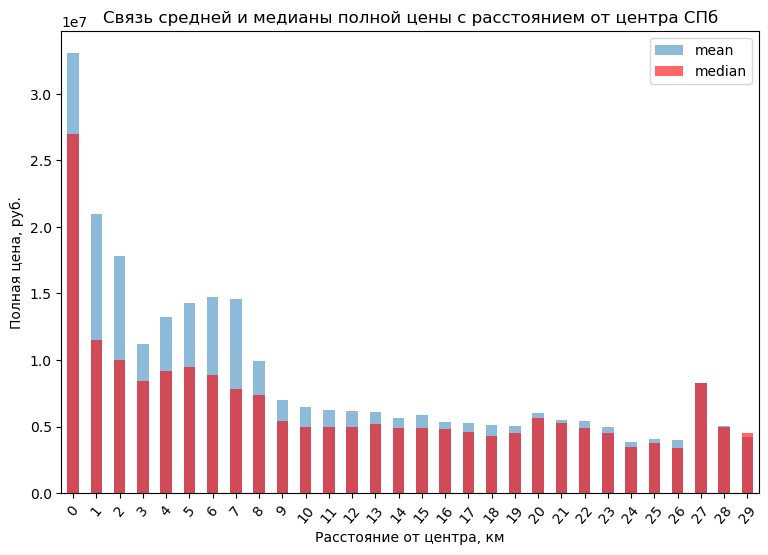

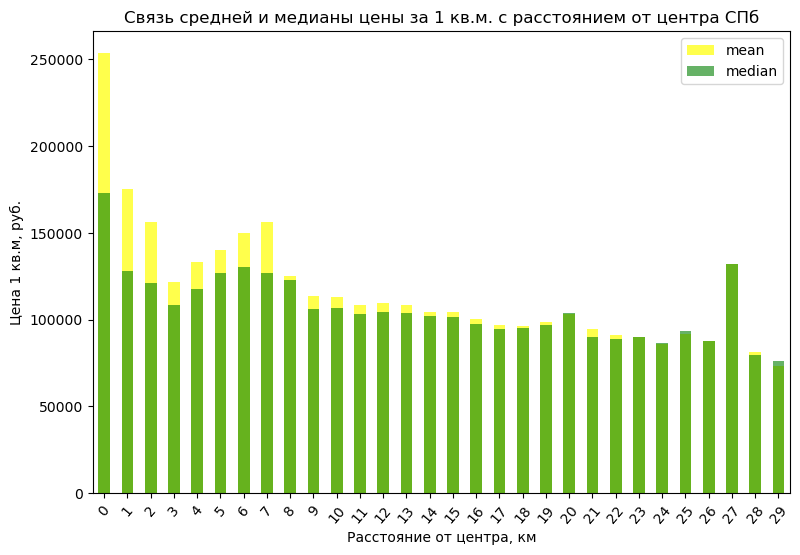

In [120]:
ax = data_spb_full.plot(kind='bar', x='km_to_cityCenter', y='mean', linewidth=5, alpha=0.5, label='mean', 
                  legend=True, title='Связь средней и медианы полной цены с расстоянием от центра СПб', 
                  ylabel='Полная цена, руб.')
data_spb_full.plot(kind='bar', x='km_to_cityCenter', y='median', linewidth=5, alpha=0.6, label='median', rot=50,
                   ax=ax, color ='red', legend=True, xlabel='Расстояние от центра, км', figsize=(9,6))
plt.show()

bx = data_spb_sqm.plot(kind='bar', x='km_to_cityCenter', y='mean', linewidth=5, alpha=0.7, label='mean', 
                  legend=True, title='Связь средней и медианы цены за 1 кв.м. с расстоянием от центра СПб', 
                  ylabel='Цена 1 кв.м, руб.', color ='yellow')
data_spb_sqm.plot(kind='bar', x='km_to_cityCenter', y='median', linewidth=5, alpha=0.6, label='median', rot=50,
                   ax=bx, color ='green', legend=True, xlabel='Расстояние от центра, км', figsize=(9,6))
plt.show()

**Вывод:**
- видна тенденция плавного снижения стоимости квартир и цены 1 кв.м по мере удаления от центра СПб 
- самые дорогие в датафрейме - квартиры расположенные вплотную (0 км) к центру
- для расстояний 1-3 км стоимость и цена 1 кв.м сравнительно быстро понижаются, возможно это связано с изношенностью жилого фонда + необходимостью для покупателя вкладываться в недешёвый ремонт
- спад стоимости на при этом происходит быстрее, чем цены 1 кв.м, возможно, из этого следует, что в среднем площадь продаваемых квартир по мере удаления от центра снижается
- затем, в радиусе от 4 до 8 км, цены подрастают, после чего продолжают снижение, видимо, мы можем корректно оценить понятие "квартира в центре" для СПб - как квартира в радиусе до 8 км от центра Санкт-Петербурга
- всплеск цены в сильно удалённых от центра объектах (27-29 км) связан во-первых с единичным числом данных для усреднения (что заметно повышает вклад цены отдельного предложения), а во-вторых - с возможной близостью таких квартир к неким объектам, которые могут повысить стоимость покупки (пляж, загородные дворцы, известные парки и т.п.) уже вне связи с расстоянием до центра
- заметно существенное расхождение mean и median в ближних к центру районах, что можно объяснить выбросами, когда на бОльшую цену влияет не только удалённость непосредственно от центра, но и близость к тем или иным объектам (театры, музеи, парки и т.п.), по мере удаления от центра (8-9 км) расхождение (соответственно и влияние выбросов) заметно снижаются

## Общий вывод

- представленный датафрейм содержит сводные данные по рынку недвижимости СПб и ЛенОбласти за 4 года (конец ноября 2014 - начало мая 2019), основан на заполненных пользователями анкетах/объявлениях с параметрами квартир + дополнительными картографическими данными
- целью проекта являлось исследование представленного датафрейма, обработка и подготовка данных к анализу, устранение дубликатов, локализация и по возможности исправление аномальных и недостающих значений в данных, а также последующий анализ - изучение максимально влияющих на цену недвижимости факторов (площади, этажности объекта, его удалённости от центра и т.п.) 


 - в рамках предобработки:
 1. Заменили пропуски в данных медианными значениями (там, где это было возможно), ориентируясь на общность ряда характеристик для конкретных населённых пунктов
 2. Обнаружили, что если для пользовательских данных подобная замена возможна (с ограничениями), то для картографических данных её произвести невозможно, в связи с недостатком информации и отсутствием источников для восполнения пропусков
 3. В связи с тем, что при дальнейшем анализе картографические данные  практически не использовались, оставили строки, содержащие в них пропуски, в датафрейме
 4. Используя доступную в интернете информацию для СПб и Лен. области (о стандартных высотах, площадях квартир, этажности и т.п.), произвели коррекцию данных и удаление аномальных значений в пользовательских данных
 5. В ряде случаев, в связи с невозможностью коррекции = удалили строки с аномалиями из датафрейма (не более 1% от общего массива данных) 


 - после этого приступили к анализу, результатом которого стали несколько наблюдений:
 1. Основной массив представленной в датафрейме недвижимости - квартиры, общей площадью до 75 кв. метров, с 1-3 комнатами, жилой площадью до 50 кв.м и кухнями 10 кв.м и стандартными потолками 2-4-2.7 м., что соответствует массовой застройке советских времён \
 1а. Наряду с этим встречаются и эксклюзивные предложения, с многосотметровыми квартирами (возможно, досоветской постройки)
 2. Прямой зависимости стоимости жилья (1 кв.м) от таких факторов, как общая/жилая площадь и размеры кухни не обнаружено, уровень цены колебался на протяжении исследуемого периода в пределах 90-95 тыс. руб. (без поправки на инфляцию за эти годы) \
 - 2а. Ярко выражена зависимость стоимости квартир от расположения: нижние этажи заметно (на единицы процентов) дешевле других, верхние этажи также продаются с дисконтом по сравнению со "средними" \
 - 2б. Наблюдается также некоторая связь между стоимостью/ценой и размещением объявления в определённый день и месяц (размещённые в субботу объявления как правило с более низкой ценой, чем в любой из будних дней; в течение года выражена сезонность - после "дорогого" апреля в мае-июне наблдается спад предложений и снижение цен. В обоих примерах речь идёт о единицах процентов \
  - 2в. Отчётливо наблюдался кризис на рынке недвижимости с удешевлением квартир в 2015-217 годах и восстановительный рост в 2018 - начале 2019 \
  - 2г. Цена 1 кв.м наиболее велика в студиях и 1к квартирах, ниже всего - в 3 к.квартирах, после чего с увеличением числа комнат начинается рост цены, что можно объяснить разным "уровнем" квартир (до 3к. - "стандартное" жильё, выше - "бизнес" или "люкс" классы), рост продолжается до числа комнат в 7, после чего уровень цен стабилизируется. Разница между "наибольшей" и "наименьшей" ценой составляет заметную величину ~ 10%
 3. Были исследованы цены на 1 кв.м. в крупнейших городах, в лидерах, как и ожидалось, оказался Санкт-Петербург, как город с максимальным предложением разнообразной, включая престижную, недвидимости. Замыкает десятку городов Выборг, с почти 2х кратным отставанием по цене 1 кв.м от лидера списка.
 4. Была проверена зависимость цены и стоимости от расстояния до центра Санкт-Петербурга, выяснилось, что в ближайшей окрестности центра (до 1 км) предлагались максимальные по цене варианты, также высоко в исследуемый период ценились квартиры в радиусе 3-8 км (что можно считать "границей" для центра Санкт-Петербурга). В пределах центра СПб наблюджаются существеные выбросы в ценах квартир, когда более высокая цена (в пересчётек на 1 кв.м)  связана не только с расстоянием, но с расположением относительно значимых "центральных" объектов города